# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr

from meteo_utils import kelvin_to_celsius
from data_utils import (
    get_data_for_barrier_plot,
    time_of_maximum_error,
)

from plot_utils import add_headers

import cartopy.crs as ccrs

from matplotlib import gridspec

from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, Normalize, LinearSegmentedColormap

In [2]:
# plotting setup
plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.dpi"] = 300
plt.style.use("tableau-colorblind10")

alphabet_letters = np.array(
    list(map(chr, range(65, 91)))
)  # used for labelling subplots
textwidth = 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch  # textwidth in inches

In [3]:
def add_label_to_axes(ax: mpl.axes.Axes, label: str):
    """Small helper function that adds a label to an Axes of a matplotlib plot.

    Args:
        ax (mpl.axes.Axes): A matplotlib axes.
        label (str): A label to add to the axes.

    """
    ax.text(
        0.02,
        0.95,
        label,
        ha="left",
        va="top",
        bbox={
            "facecolor": "white",
            "edgecolor": "none",
            "boxstyle": "square",
            "pad": 0.2,
        },
        transform=ax.transAxes,
    )


letters = ["A", "B", "C", "D", "E", "F", "G"]

In [4]:
# locations of three mayor population centers:
lats = np.array([49.25, 47.5, 45.5])
lons = np.array([-123, -122.25, -122.75]) % 360
labels = ["Vancouver", "Seattle", "Portland"]

forecast_horizon_days = 10

In [5]:
# load preprocessed data.
gt_data = xr.open_dataset("data/2021_PNW_heatwave_gt.nc")
fc_data = xr.open_dataset("data/2021_PNW_heatwave_fc.nc")

era5_climatology = xr.open_dataset("data/2021_PNW_heatwave_climatology.nc")

/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)
/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)
/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)


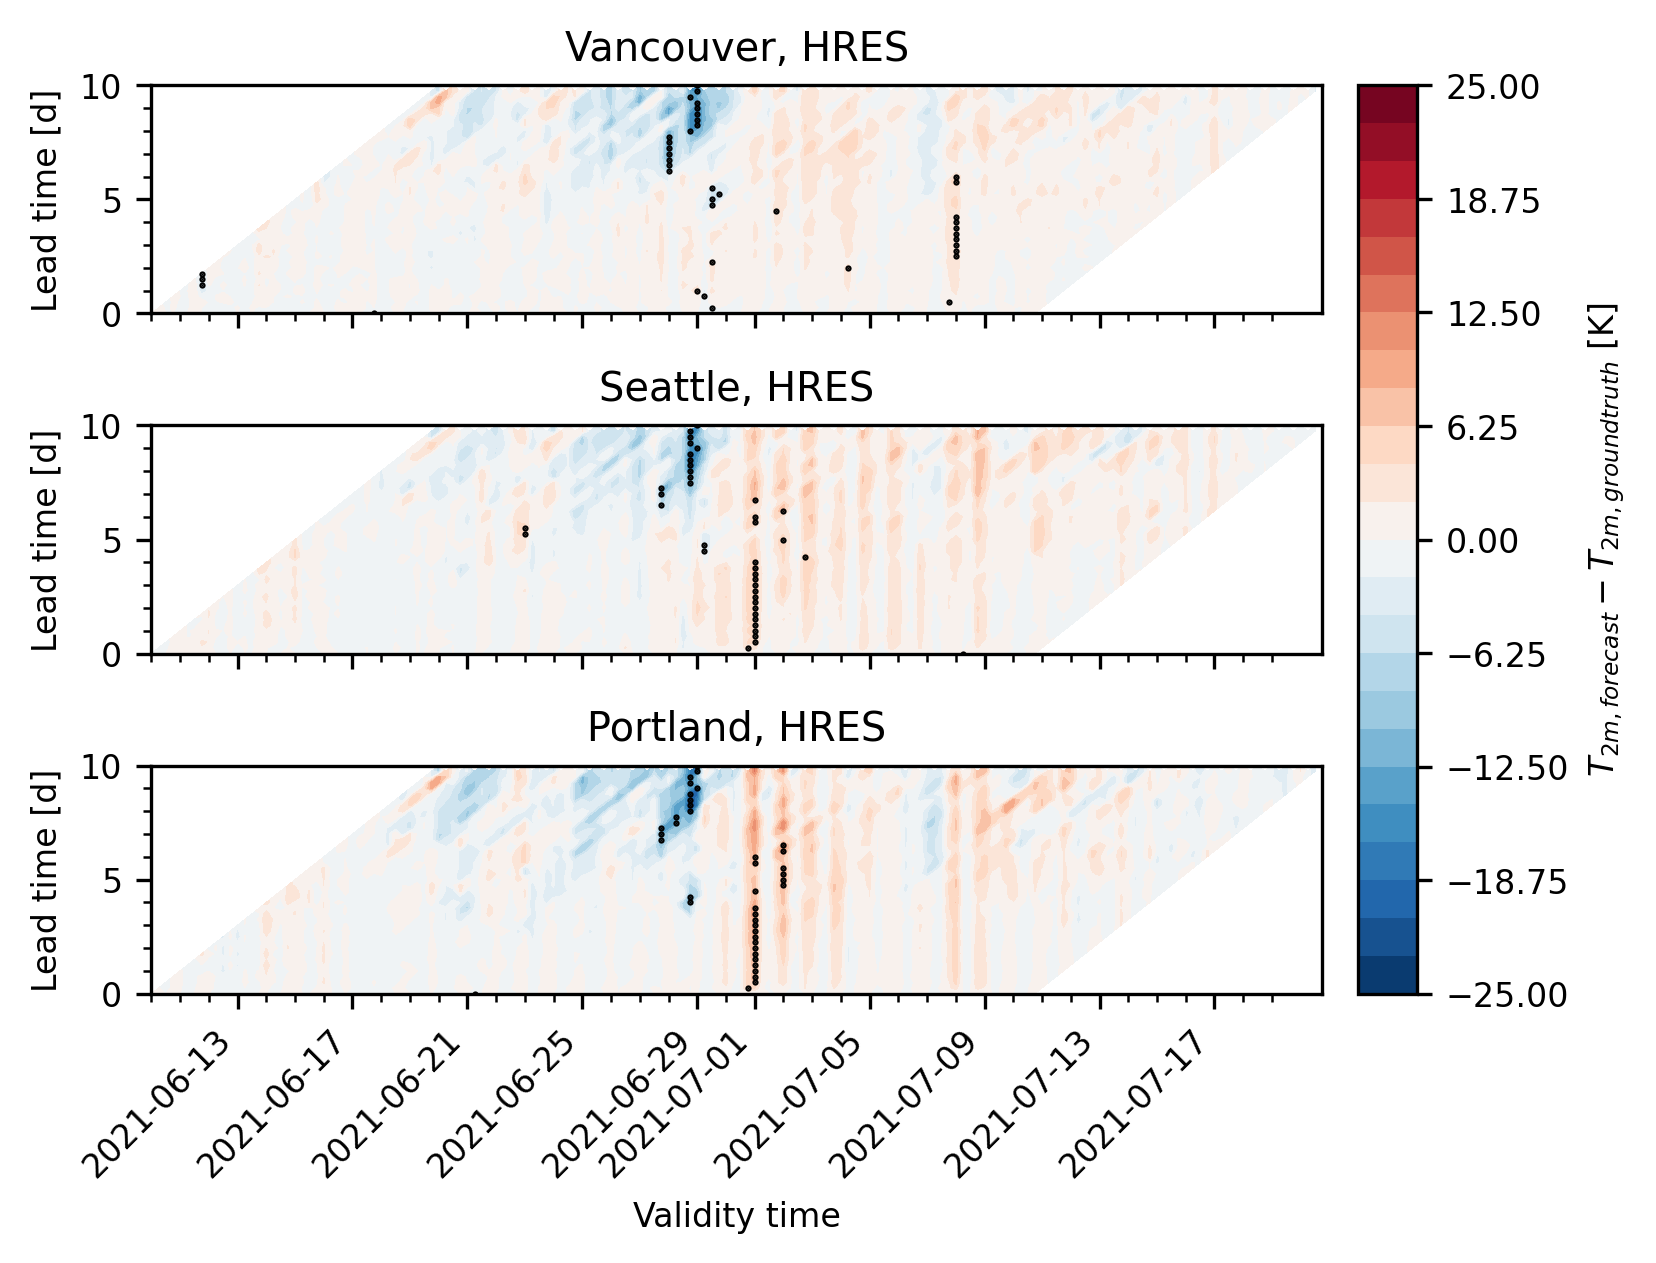

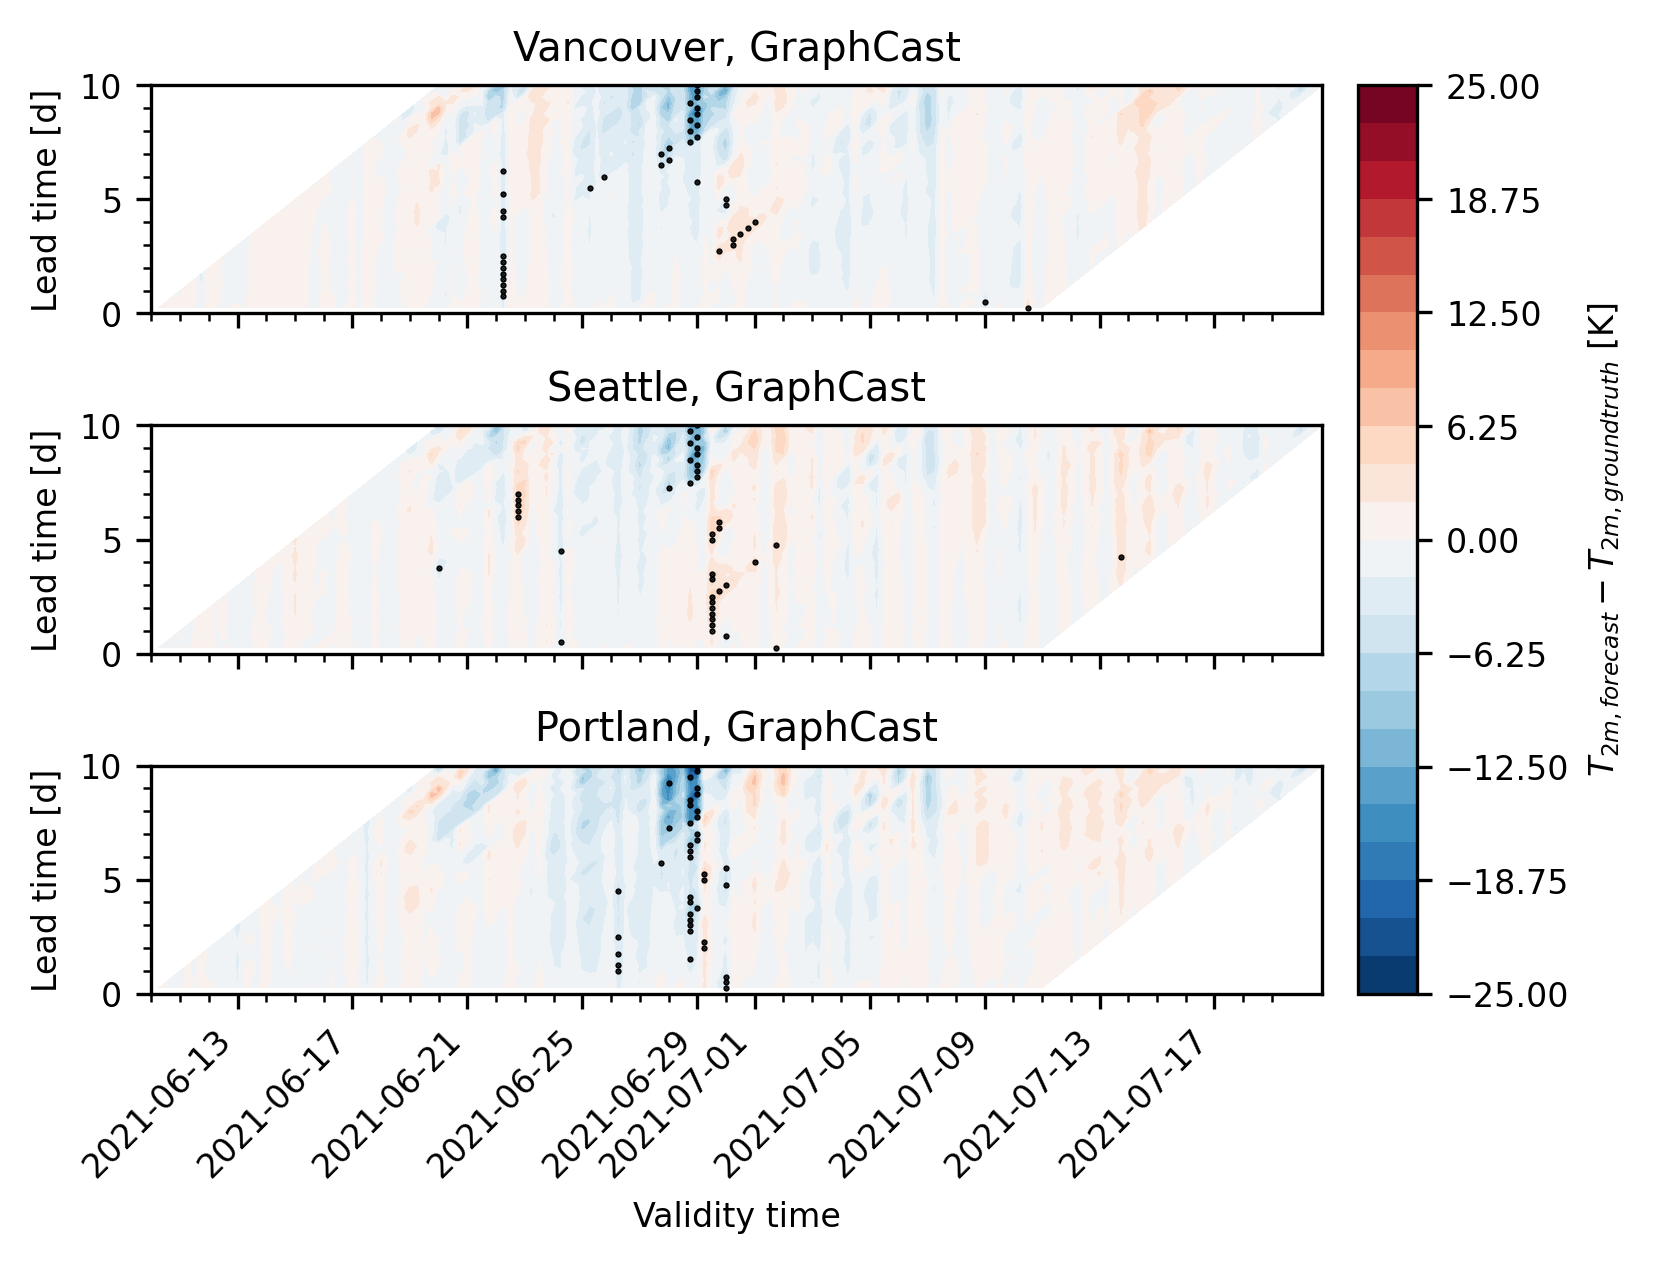

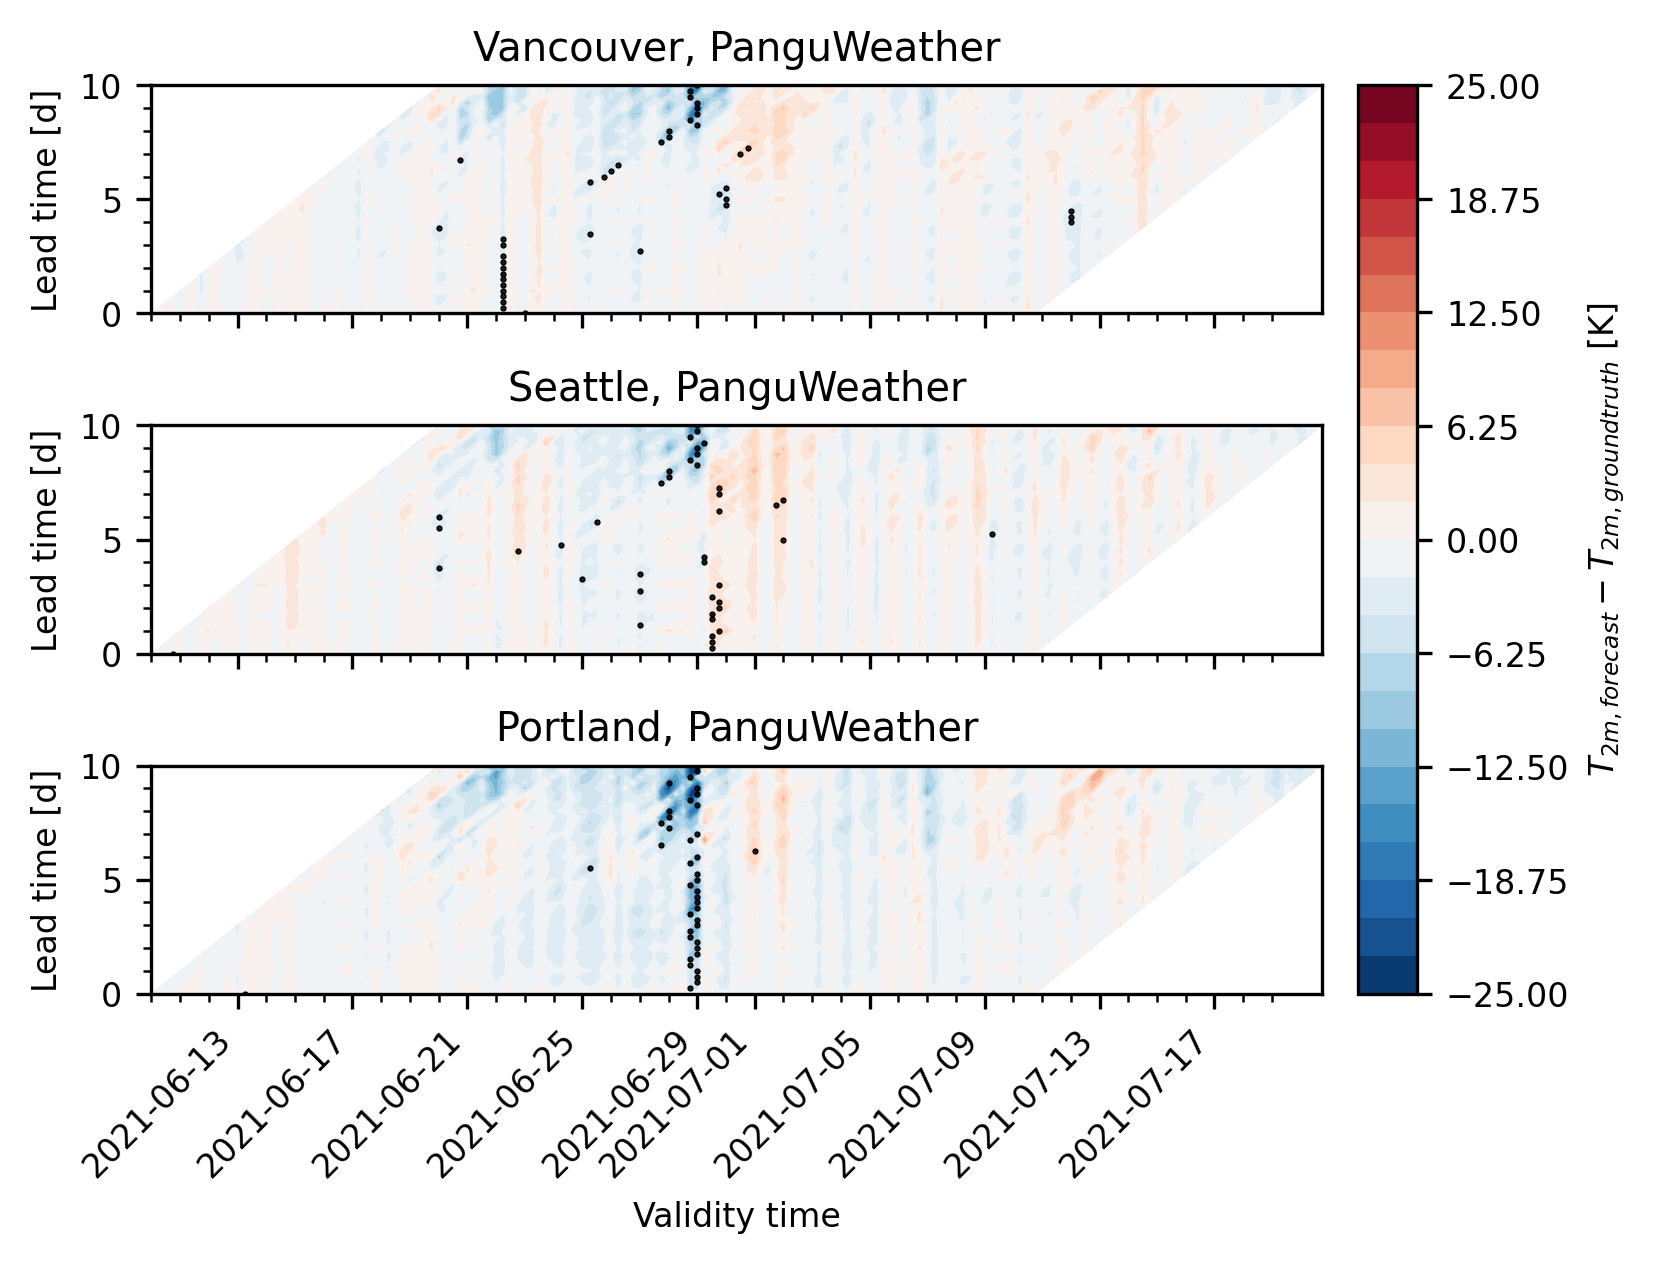

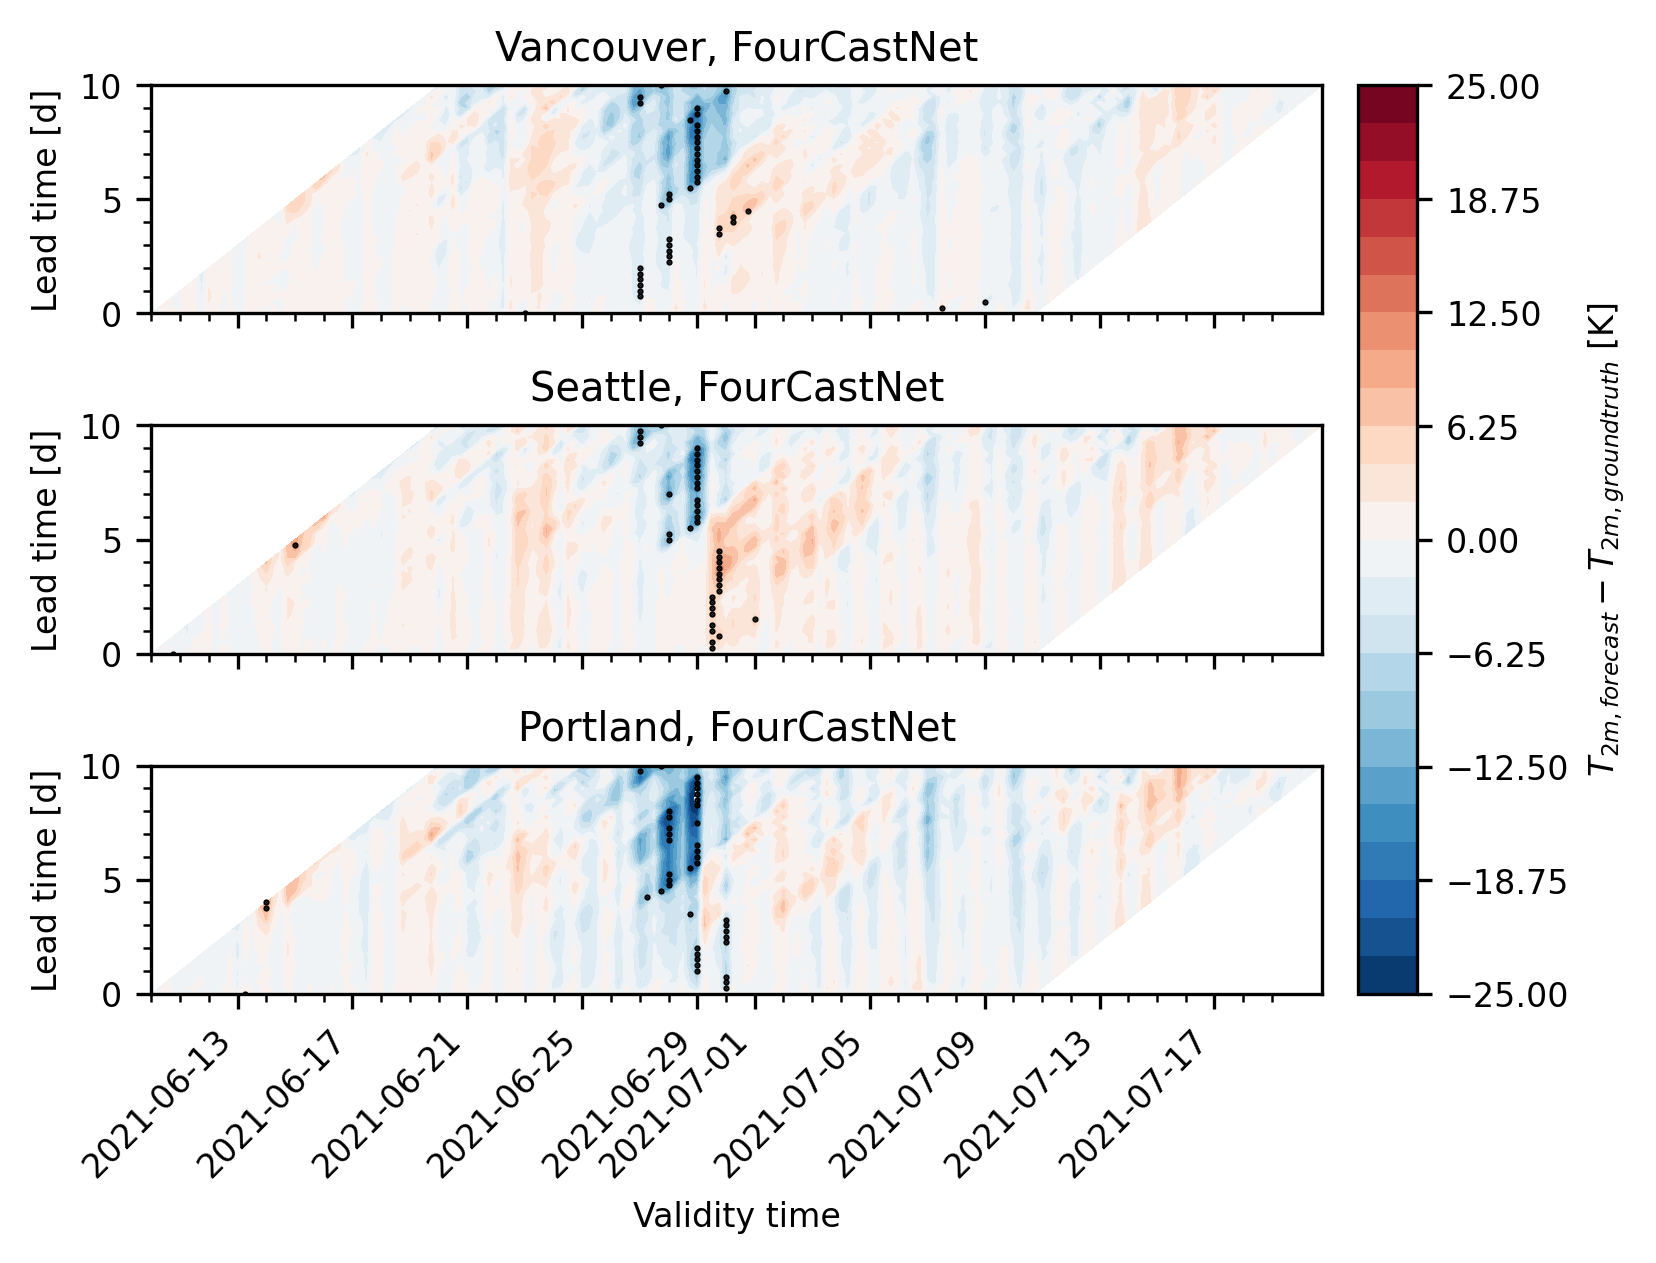

In [6]:
aspect_ratio_single_plot = 4

vmin = -25
vmax = 25
steps = 25

xticks_interval = 1

forecast_names = ["HRES", "GraphCast", "PanguWeather", "FourCastNet"]
ground_truth_names = ["HRES_t0", "ERA5", "ERA5", "ERA5"]

for fc_name, gt_name in zip(forecast_names, ground_truth_names, strict=True):
    fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 3))
    gs = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1, 0.05])

    for i, (lat, lon) in enumerate(zip(lats, lons, strict=True)):
        ax = fig.add_subplot(gs[i, 0])

        d = get_data_for_barrier_plot(
            gt=gt_data.sel(source=gt_name)
            .sel({"latitude": lat, "longitude": lon}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
            fc=fc_data.sel(forecast=fc_name)
            .sel({"latitude": lat, "longitude": lon}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
        )
        d = d.assign_coords(
            prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
        )  # convert to number of days to make plotting nicer

        contour = plt.contourf(
            d.valid_time,
            d.prediction_timedelta,
            d.to_numpy().T,
            cmap="RdBu_r",
            levels=np.linspace(vmin, vmax, steps),
        )

        # find max biases at each lead time:
        i_x_max = time_of_maximum_error(d.to_numpy().T)
        i_y_max = np.arange(len(d.prediction_timedelta))[~np.isnan(i_x_max)].astype(int)
        i_x_max = i_x_max[~np.isnan(i_x_max)].astype(int)
        ax.scatter(
            d.valid_time[i_x_max],
            d.prediction_timedelta[i_y_max],
            marker=".",
            c="k",
            s=1,
        )

        ax.set_xlabel("Validity time")
        ax.set_ylabel("Time since start of forecast [days]")

        # configure and plot grid.
        ax.set_yticks(np.arange(d.prediction_timedelta[-1]), minor=True)
        ax.set_xticks(
            d.valid_time.to_numpy()[0]
            + np.arange(
                int(
                    (d.valid_time.to_numpy()[-1] - d.valid_time.to_numpy()[0])
                    / np.timedelta64(xticks_interval, "D")
                )
            )
            * np.timedelta64(xticks_interval, "D"),
            minor=True,
        )

        # rotate x labels so that they don't overlap
        if i == len(lats) - 1:
            plt.xticks(rotation=45, ha="right")
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xlabel("")

        ax.set_ylabel("Lead time [d]")
        ax.set_title(f"{labels[i]}, {fc_name}")

    ax_cbar = fig.add_subplot(gs[:, 1])
    plt.colorbar(
        contour, label="$T_{2m, forecast} - T_{2m, ground truth}$ [K]", cax=ax_cbar
    )
    plt.tight_layout()

    plt.savefig(f"images/2021_PNW_heatwave_predictability_barrier_{fc_name}.png")

/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)
/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)
/gpfs1/schlecker/home/wider/Projects/ClimateTransformers/data_utils.py:49: RuntimeWarning: All-NaN slice encountered
  d0 = np.nanmin(arr, axis=1)


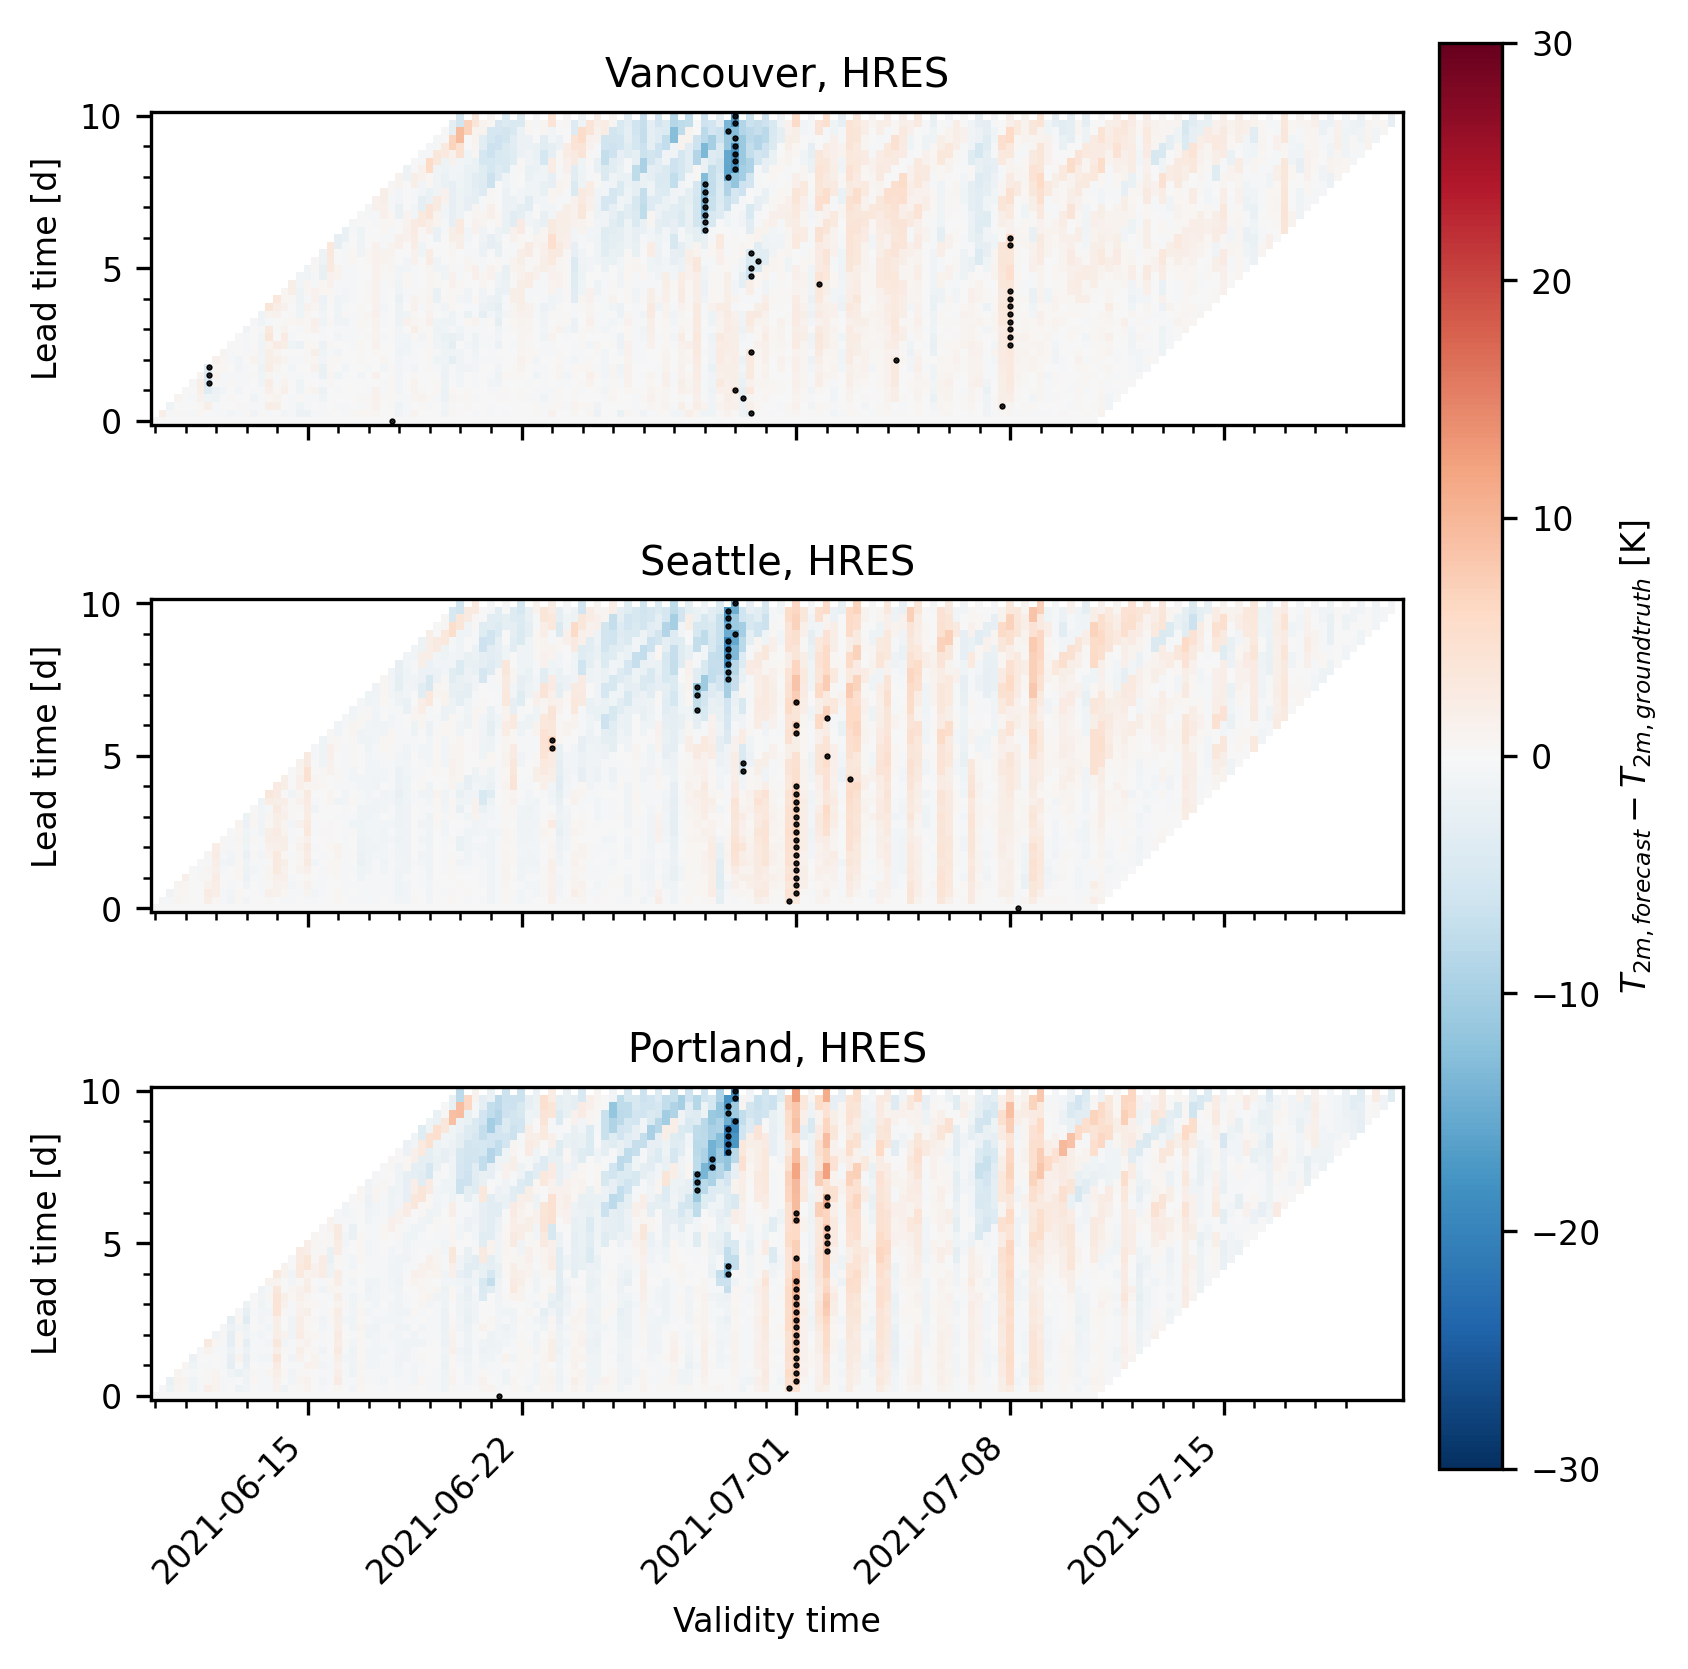

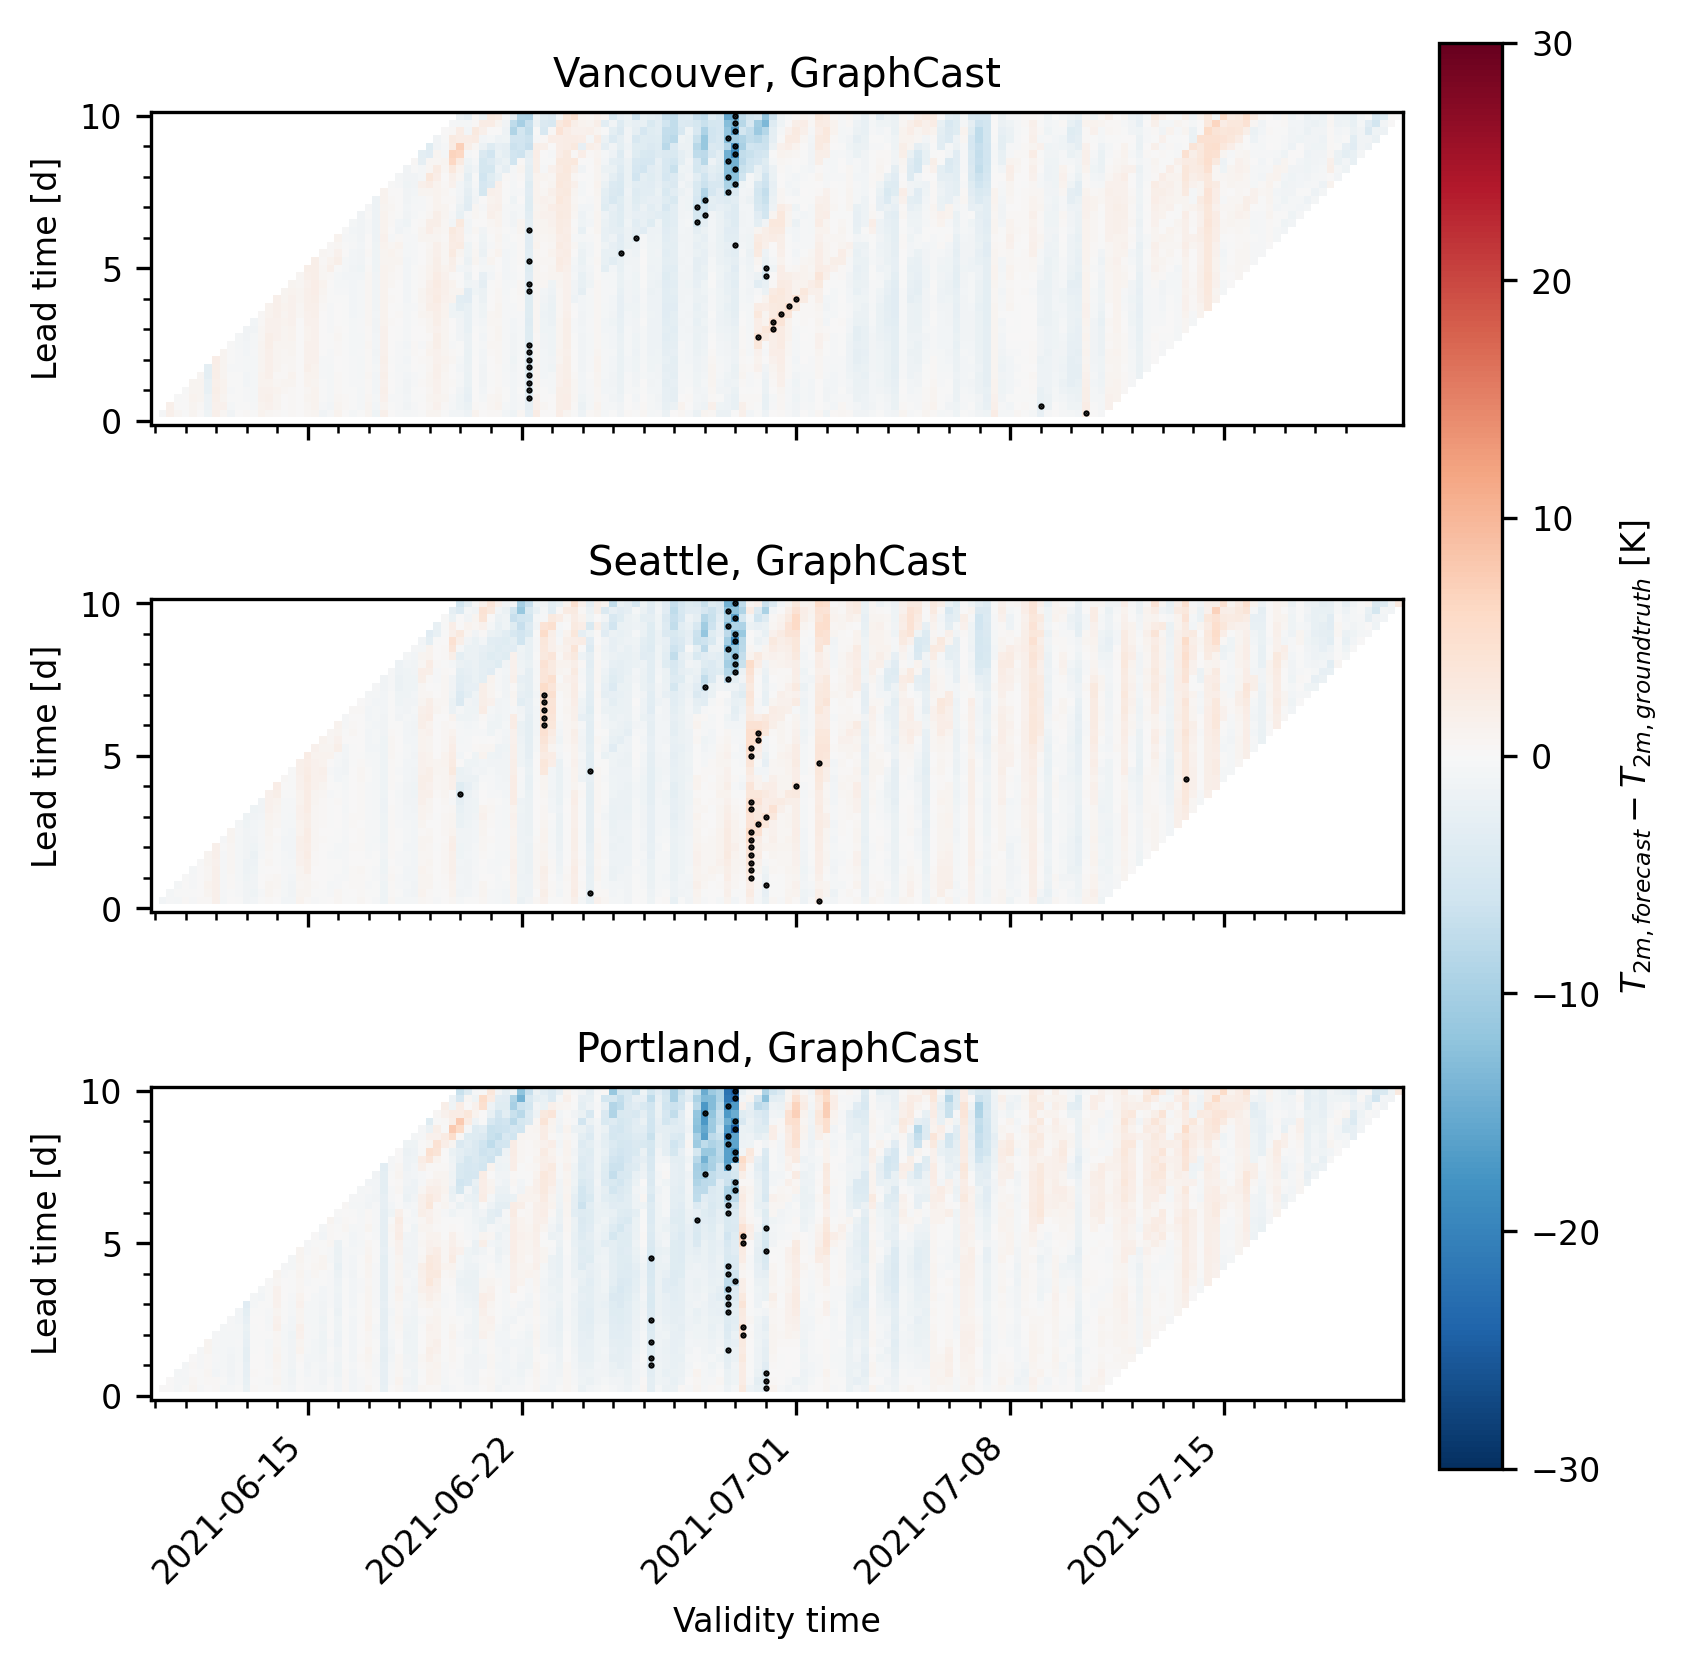

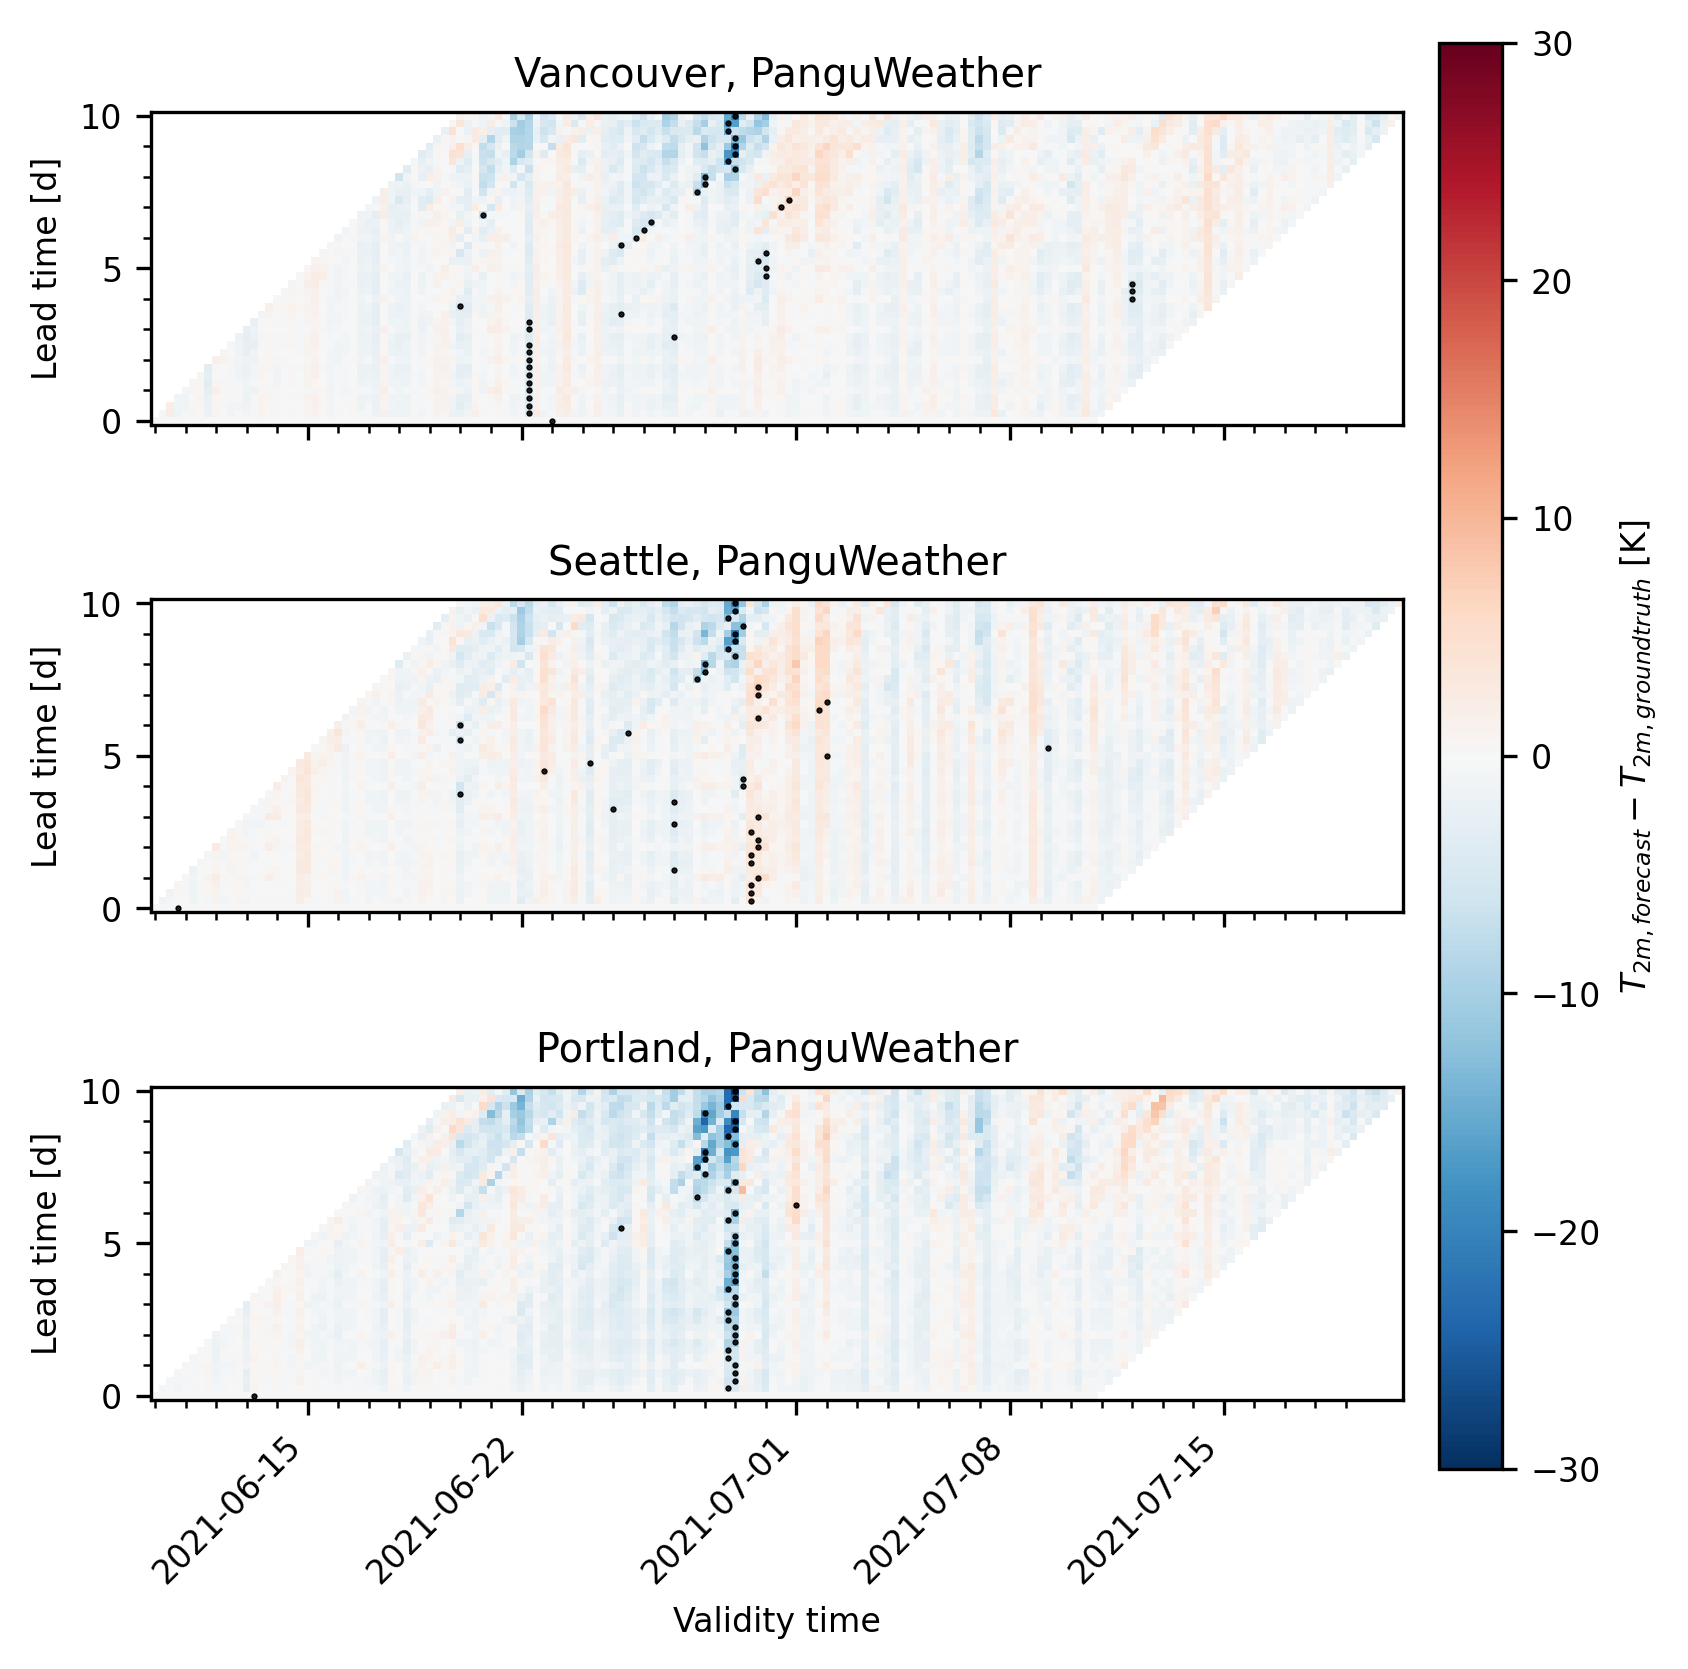

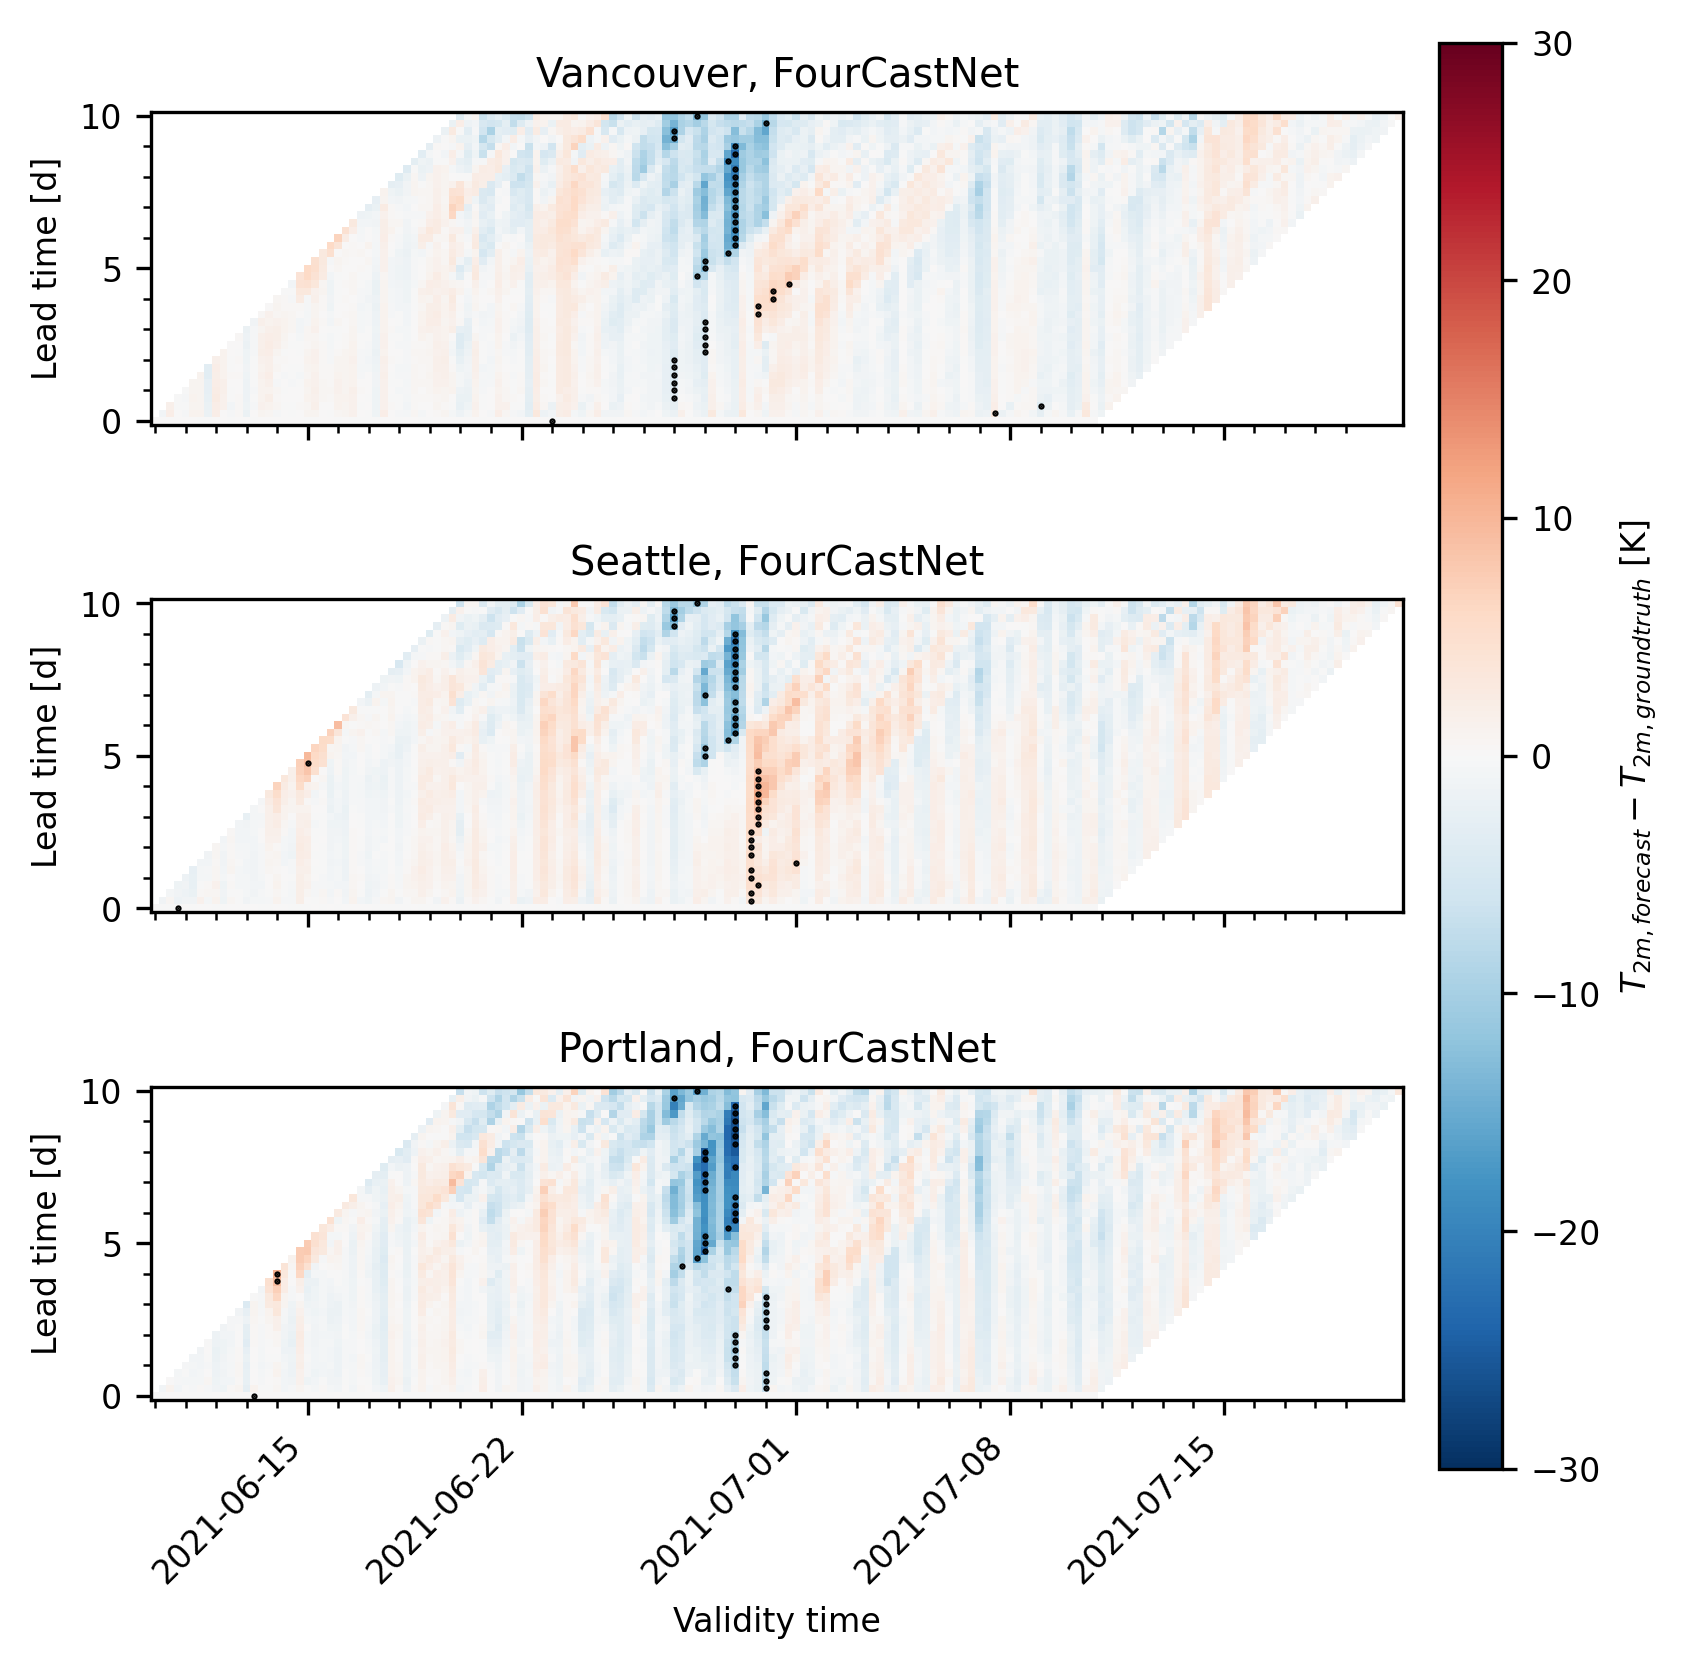

In [7]:
aspect_ratio_single_plot = 3

vmin = -30
vmax = 30

xticks_interval = 1

for fc_name, gt_name in zip(forecast_names, ground_truth_names, strict=True):
    fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 3))
    gs = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1, 0.05])

    for i, (lat, lon) in enumerate(zip(lats, lons, strict=True)):
        ax = fig.add_subplot(gs[i, 0])

        d = get_data_for_barrier_plot(
            gt=gt_data.sel(source=gt_name)
            .sel({"latitude": lat, "longitude": lon}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
            fc=fc_data.sel(forecast=fc_name)
            .sel({"latitude": lat, "longitude": lon}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
        )
        d = d.assign_coords(
            prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
        )  # convert to number of days to make plotting nicer

        dx = d.valid_time.to_numpy()[1] - d.valid_time.to_numpy()[0]
        dy = d.prediction_timedelta.to_numpy()[1] - d.prediction_timedelta.to_numpy()[0]

        im = ax.imshow(
            d.to_numpy().T,
            interpolation="nearest",
            vmin=vmin,
            vmax=vmax,
            cmap="RdBu_r",
            extent=[
                d.valid_time.to_numpy()[0] - dx / 2,
                d.valid_time.to_numpy()[-1] + dx / 2,
                d.prediction_timedelta.to_numpy()[-1] + dy / 2,
                d.prediction_timedelta.to_numpy()[0] - dy / 2,
            ],
        )

        # find max biases at each lead time:
        i_x_max = time_of_maximum_error(d.to_numpy().T)
        i_y_max = np.arange(len(d.prediction_timedelta))[~np.isnan(i_x_max)].astype(int)
        i_x_max = i_x_max[~np.isnan(i_x_max)].astype(int)
        ax.scatter(
            d.valid_time[i_x_max],
            d.prediction_timedelta[i_y_max],
            marker=".",
            c="k",
            s=1,
        )

        ax.set_xlabel("Validity time")
        ax.set_ylabel("Time since start of forecast [days]")

        # configure and plot grid.
        ax.invert_yaxis()
        ax.set_yticks(np.arange(d.prediction_timedelta[-1]), minor=True)
        ax.set_xticks(
            d.valid_time.to_numpy()[0]
            + np.arange(
                int(
                    (d.valid_time.to_numpy()[-1] - d.valid_time.to_numpy()[0])
                    / np.timedelta64(xticks_interval, "D")
                )
            )
            * np.timedelta64(xticks_interval, "D"),
            minor=True,
        )

        # rotate x labels so that they don't overlap
        if i == len(lats) - 1:
            plt.xticks(rotation=45, ha="right")
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xlabel("")

        ax.set_ylabel("Lead time [d]")
        ax.set_title(f"{labels[i]}, {fc_name}")
        ax.set_aspect("equal")

    ax_cbar = fig.add_subplot(gs[:, 1])
    plt.colorbar(im, label="$T_{2m, forecast} - T_{2m, ground truth}$ [K]", cax=ax_cbar)
    plt.tight_layout()

    plt.savefig(
        f"images/2021_PNW_heatwave_predictability_barrier_pixels_{fc_name}_new.png"
    )

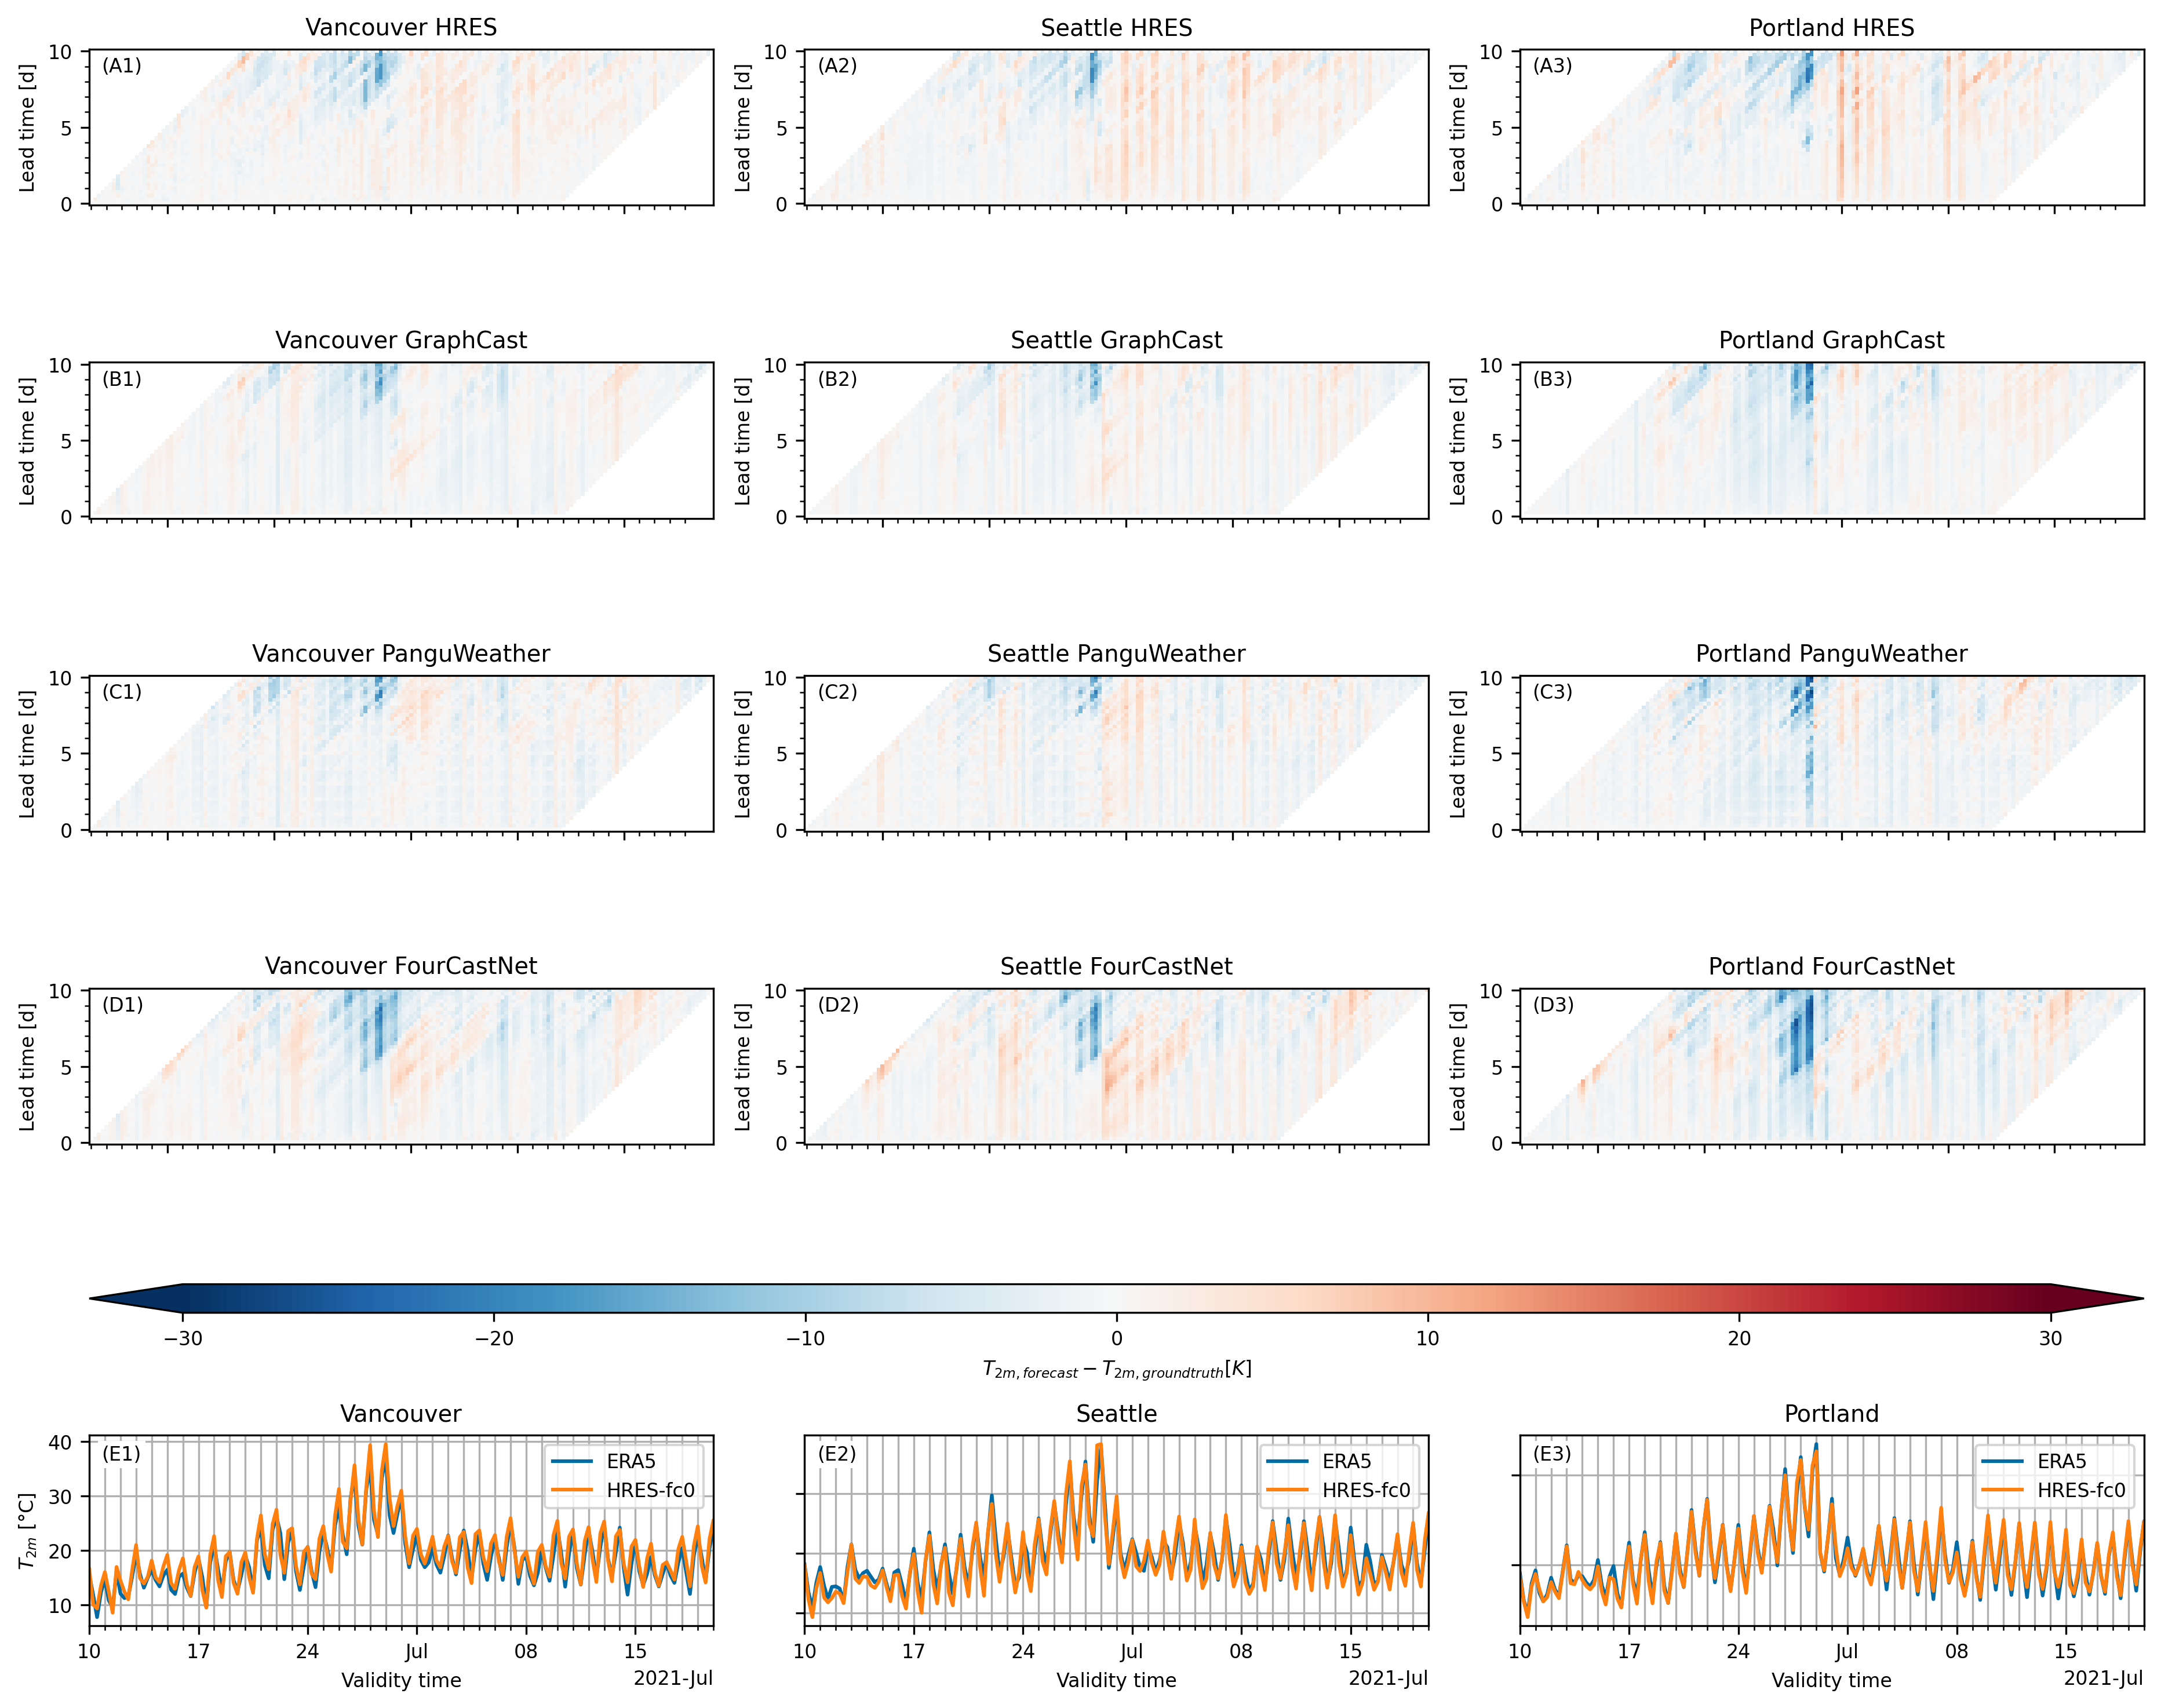

In [8]:
aspect_ratio_single_plot = 1.7

vmin = -30
vmax = 30

# this figure is too large to display it at normal textwidth. therefore increase width by factor
w_factor = 2.2
fig = plt.figure(
    figsize=(
        w_factor * textwidth,
        w_factor * textwidth / aspect_ratio_single_plot * 4 / 3,
    )
)
gs = gridspec.GridSpec(6, 3, figure=fig, height_ratios=4 * [1] + [0.15] + [1])

rmse_indices = [10, 20]  # forecasts with leadtime 120h, 240h

for j, label in enumerate(labels):
    ax_timeseries = fig.add_subplot(gs[-1, j])

    t_min = np.amin(gt_data.time).to_numpy()
    t_max = np.amax(gt_data.time).to_numpy()
    n_days = np.ceil((t_max - t_min) / np.timedelta64(1, "D"))
    ticks = t_min + np.timedelta64(1, "D") * np.arange(n_days)

    d = kelvin_to_celsius(
        gt_data.sel({"latitude": lats[j], "longitude": lons[j], "source": "ERA5"})[
            "2m_temperature"
        ]
    )
    d.plot(ax=ax_timeseries, label="ERA5")

    d = kelvin_to_celsius(
        gt_data.sel({"latitude": lats[j], "longitude": lons[j], "source": "HRES_t0"})[
            "2m_temperature"
        ]
    )
    d.plot(ax=ax_timeseries, label="HRES-fc0")

    ax_timeseries.set_xticks(ticks, minor=True)
    ax_timeseries.set_xticks(ticks[::7])
    ax_timeseries.set_xlim(np.amin(ticks), np.amax(ticks))
    ax_timeseries.set_title(f"{label}")
    if j == 0:
        ax_timeseries.set_ylabel("$T_{2m}$ [°C]")
    else:
        ax_timeseries.set_ylabel("")
        plt.setp(ax_timeseries.get_yticklabels(), visible=False)
    ax_timeseries.set_xlabel("Validity time")
    ax_timeseries.grid(visible=True, which="both")
    ax_timeseries.legend(loc="upper right")

    add_label_to_axes(ax_timeseries, label=f"({letters[len(forecast_names)]}{j+1})")

    for i, (fc_name, gt_name) in enumerate(
        zip(forecast_names, ground_truth_names, strict=True)
    ):
        ax = fig.add_subplot(gs[i, j])
        d = get_data_for_barrier_plot(
            gt=gt_data.sel(source=gt_name)
            .sel({"latitude": lats[j], "longitude": lons[j]}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
            fc=fc_data.sel(forecast=fc_name)
            .sel({"latitude": lats[j], "longitude": lons[j]}, method="nearest")[
                "2m_temperature"
            ]
            .compute(),
        )
        d = d.assign_coords(
            prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
        )  # convert to number of days to make plotting nicer

        dx = d.valid_time.to_numpy()[1] - d.valid_time.to_numpy()[0]
        dy = d.prediction_timedelta.to_numpy()[1] - d.prediction_timedelta.to_numpy()[0]

        im = ax.imshow(
            d.to_numpy().T,
            interpolation="nearest",
            vmin=vmin,
            vmax=vmax,
            cmap="RdBu_r",
            extent=[
                d.valid_time.to_numpy()[0] - dx / 2,
                d.valid_time.to_numpy()[-1] + dx / 2,
                d.prediction_timedelta.to_numpy()[-1] + dy / 2,
                d.prediction_timedelta.to_numpy()[0] - dy / 2,
            ],
        )

        ax.set_xlabel("Validity time")
        ax.set_ylabel("Time since start of forecast [days]")

        # configure and plot grid.
        ax.invert_yaxis()
        ax.set_yticks(np.arange(d.prediction_timedelta[-1]), minor=True)
        ax.set_xticks(
            d.valid_time.to_numpy()[0]
            + np.arange(
                int(
                    (d.valid_time.to_numpy()[-1] - d.valid_time.to_numpy()[0])
                    / np.timedelta64(xticks_interval, "D")
                )
            )
            * np.timedelta64(xticks_interval, "D"),
            minor=True,
        )

        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

        ax.set_ylabel("Lead time [d]")
        ax.set_title(f"{label} {fc_name}")
        ax.set_aspect("equal")

        add_label_to_axes(ax, label=f"({letters[i]}{j+1})")

ax_cb = plt.subplot(gs[-2, :])
cbar = plt.colorbar(
    mappable=im,
    cax=ax_cb,
    extend="both",
    label="$T_{2m, forecast} - T_{2m, ground truth} [K]$",
    orientation="horizontal",
)


fig.canvas.draw()
plt.tight_layout()

plt.savefig(
    "images/2021_PNW_heatwave_predictability_barrier_plots_all_no_aggregate.png"
)

# RMSE plots:

Following Ben-Bouallegue, we also want to include a contour in our plot that quantifies the long-term average HRES performance.

In [9]:
def rmse_time_mean_outside_from_diff(difference: xr.DataArray) -> xr.DataArray:
    """RMSE from differences between forecasts and ground truth.

    RMSE defined as in WeatherBench 2, i.e. time mean outside square root.

    Args:
    ----
        difference (xr.DataArray): Array of differences between forecasts and ground truth.

    Returns:
    -------
        xr.DataArray: RMSE as defined in WeatherBench 2.

    """
    return np.sqrt(difference**2).mean(dim="valid_time")


def rmse_time_mean_inside_from_diff(difference: xr.DataArray) -> xr.DataArray:
    """RMSE from differences between forecasts and ground truth.

    RMSE defined as in WeatherBench 2, i.e. time mean inside square root.

    Args:
    ----
        difference (xr.DataArray): Array of differences between forecasts and ground truth.

    Returns:
    -------
        xr.DataArray: RMSE as defined in WeatherBench 2.

    """
    return np.sqrt((difference**2).mean(dim="valid_time"))


def get_rmse_time_mean_outside(gt: xr.DataArray, fc: xr.DataArray) -> xr.DataArray:
    """Compute RMSE from preprocessed ground truth and forecast data.

    Args:
    ----
        gt (xr.DataArray): Ground truth data
        fc (xr.DataArray): Forecast data (including multiple lead times).

    Returns:
    -------
        xr.DataArray: RMSE as computed in GraphCast paper.

    """
    d = get_data_for_barrier_plot(gt=gt, fc=fc)
    return d.groupby("valid_time.date").map(rmse_time_mean_outside_from_diff)


def get_rmse_time_mean_inside(gt: xr.DataArray, fc: xr.DataArray) -> xr.DataArray:
    """Compute RMSE from preprocessed ground truth and forecast data. Use definition in WeatherBench 2.

    Args:
    ----
        gt (xr.DataArray): Ground truth data
        fc (xr.DataArray): Forecast data (including multiple lead times).

    Returns:
    -------
        xr.DataArray: RMSE computed as in WeatherBench 2.

    """
    d = get_data_for_barrier_plot(gt=gt, fc=fc)
    return d.groupby("valid_time.date").map(rmse_time_mean_inside_from_diff)

In [10]:
# computing over entire weather bench dataset is time consuming,
# therefore precompute and reload if needed.
# to do precomputing: uncomment below.
"""

from tqdm.auto import tqdm

rmse_mean = {}

# retrieve data from WeatherBench 2
hres_wb = xr.open_zarr("gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr")
hres_t0_wb = xr.open_zarr(
    "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
)

# only include data whose dayofyear differs by less than 46 days
# from the dayofyear of 2021-06-28, the peak of the heat wave.
window_size = 45
heatwave_peak = np.datetime64("2021-06-28")
hres_wb = hres_wb.where(
    abs(hres_wb.time.dt.dayofyear - pd.Timestamp(heatwave_peak).dayofyear)
    <= window_size,
    drop=True,
)

# we only care about lead times spaced 12 h apart - could also look at more though.
mask = (hres_wb.prediction_timedelta / np.timedelta64(6, "h")) % 2 == 0
selected_lead_times = hres_wb.prediction_timedelta.where(mask, drop=True)


forecast_len = hres_wb.prediction_timedelta[-1] - hres_wb.prediction_timedelta[0]

for la, lo in zip(lats, lons, strict=True):
    rmse_mean[(la, lo)] = np.empty(len(selected_lead_times))

    for i_lead_time, lead_time in tqdm(enumerate(selected_lead_times.values)):
        forecasts = hres_wb.sel(
            {
                "time": slice(None, hres_wb.time[-1] - forecast_len),
                "latitude": la,
                "longitude": lo,
                "prediction_timedelta": lead_time,
            }
        )[["2m_temperature"]]
        forecasts = forecasts.assign_coords(time=forecasts.time + lead_time).rename(
            time="valid_time"
        )
        # only look at forecasts whose dayofyear is within a window around
        forecasts = forecasts.where(
            abs(
                forecasts.valid_time.dt.dayofyear
                - pd.Timestamp(np.datetime64("2021-06-28")).dayofyear
            )
            <= window_size,
            drop=True,
        )

        groundtruth = hres_t0_wb.sel(
            {"time": forecasts.valid_time.to_numpy(), "latitude": la, "longitude": lo}
        )[["2m_temperature"]].rename(time="valid_time")

        rmse_mean[(la, lo)][i_lead_time] = (
            (forecasts - groundtruth)["2m_temperature"]
            .groupby("valid_time.date")
            .map(rmse_time_mean_inside_from_diff)
            .mean()
            .to_numpy()
        )
np.save("rmse_mean.npy", rmse_mean)
"""

'\n\nfrom tqdm.auto import tqdm\n\nrmse_mean = {}\n\n# retrieve data from WeatherBench 2\nhres_wb = xr.open_zarr("gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr")\nhres_t0_wb = xr.open_zarr(\n    "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"\n)\n\n# only include data whose dayofyear differs by less than 46 days\n# from the dayofyear of 2021-06-28, the peak of the heat wave.\nwindow_size = 45\nheatwave_peak = np.datetime64("2021-06-28")\nhres_wb = hres_wb.where(\n    abs(hres_wb.time.dt.dayofyear - pd.Timestamp(heatwave_peak).dayofyear)\n    <= window_size,\n    drop=True,\n)\n\n# we only care about lead times spaced 12 h apart - could also look at more though.\nmask = (hres_wb.prediction_timedelta / np.timedelta64(6, "h")) % 2 == 0\nselected_lead_times = hres_wb.prediction_timedelta.where(mask, drop=True)\n\n\nforecast_len = hres_wb.prediction_timedelta[-1] - hres_wb.prediction_timedelta[0]\n\nfor la, lo in zip(lats, lons, strict=True):\n    rmse_mean[

In [11]:
# load preprocessed data.
rmse_mean = np.load("rmse_mean.npy", allow_pickle=True).item()

In [12]:
for label, (la, lo) in zip(labels, zip(lats, lons, strict=True), strict=True):
    print(
        f"{label}. RMSE 5 day: {rmse_mean[(la, lo)][10]:.3f}; RMSE 10 day: {rmse_mean[(la, lo)][20]:.3f}"
    )

Vancouver. RMSE 5 day: 1.527; RMSE 10 day: 2.799
Seattle. RMSE 5 day: 1.614; RMSE 10 day: 2.821
Portland. RMSE 5 day: 1.927; RMSE 10 day: 3.727


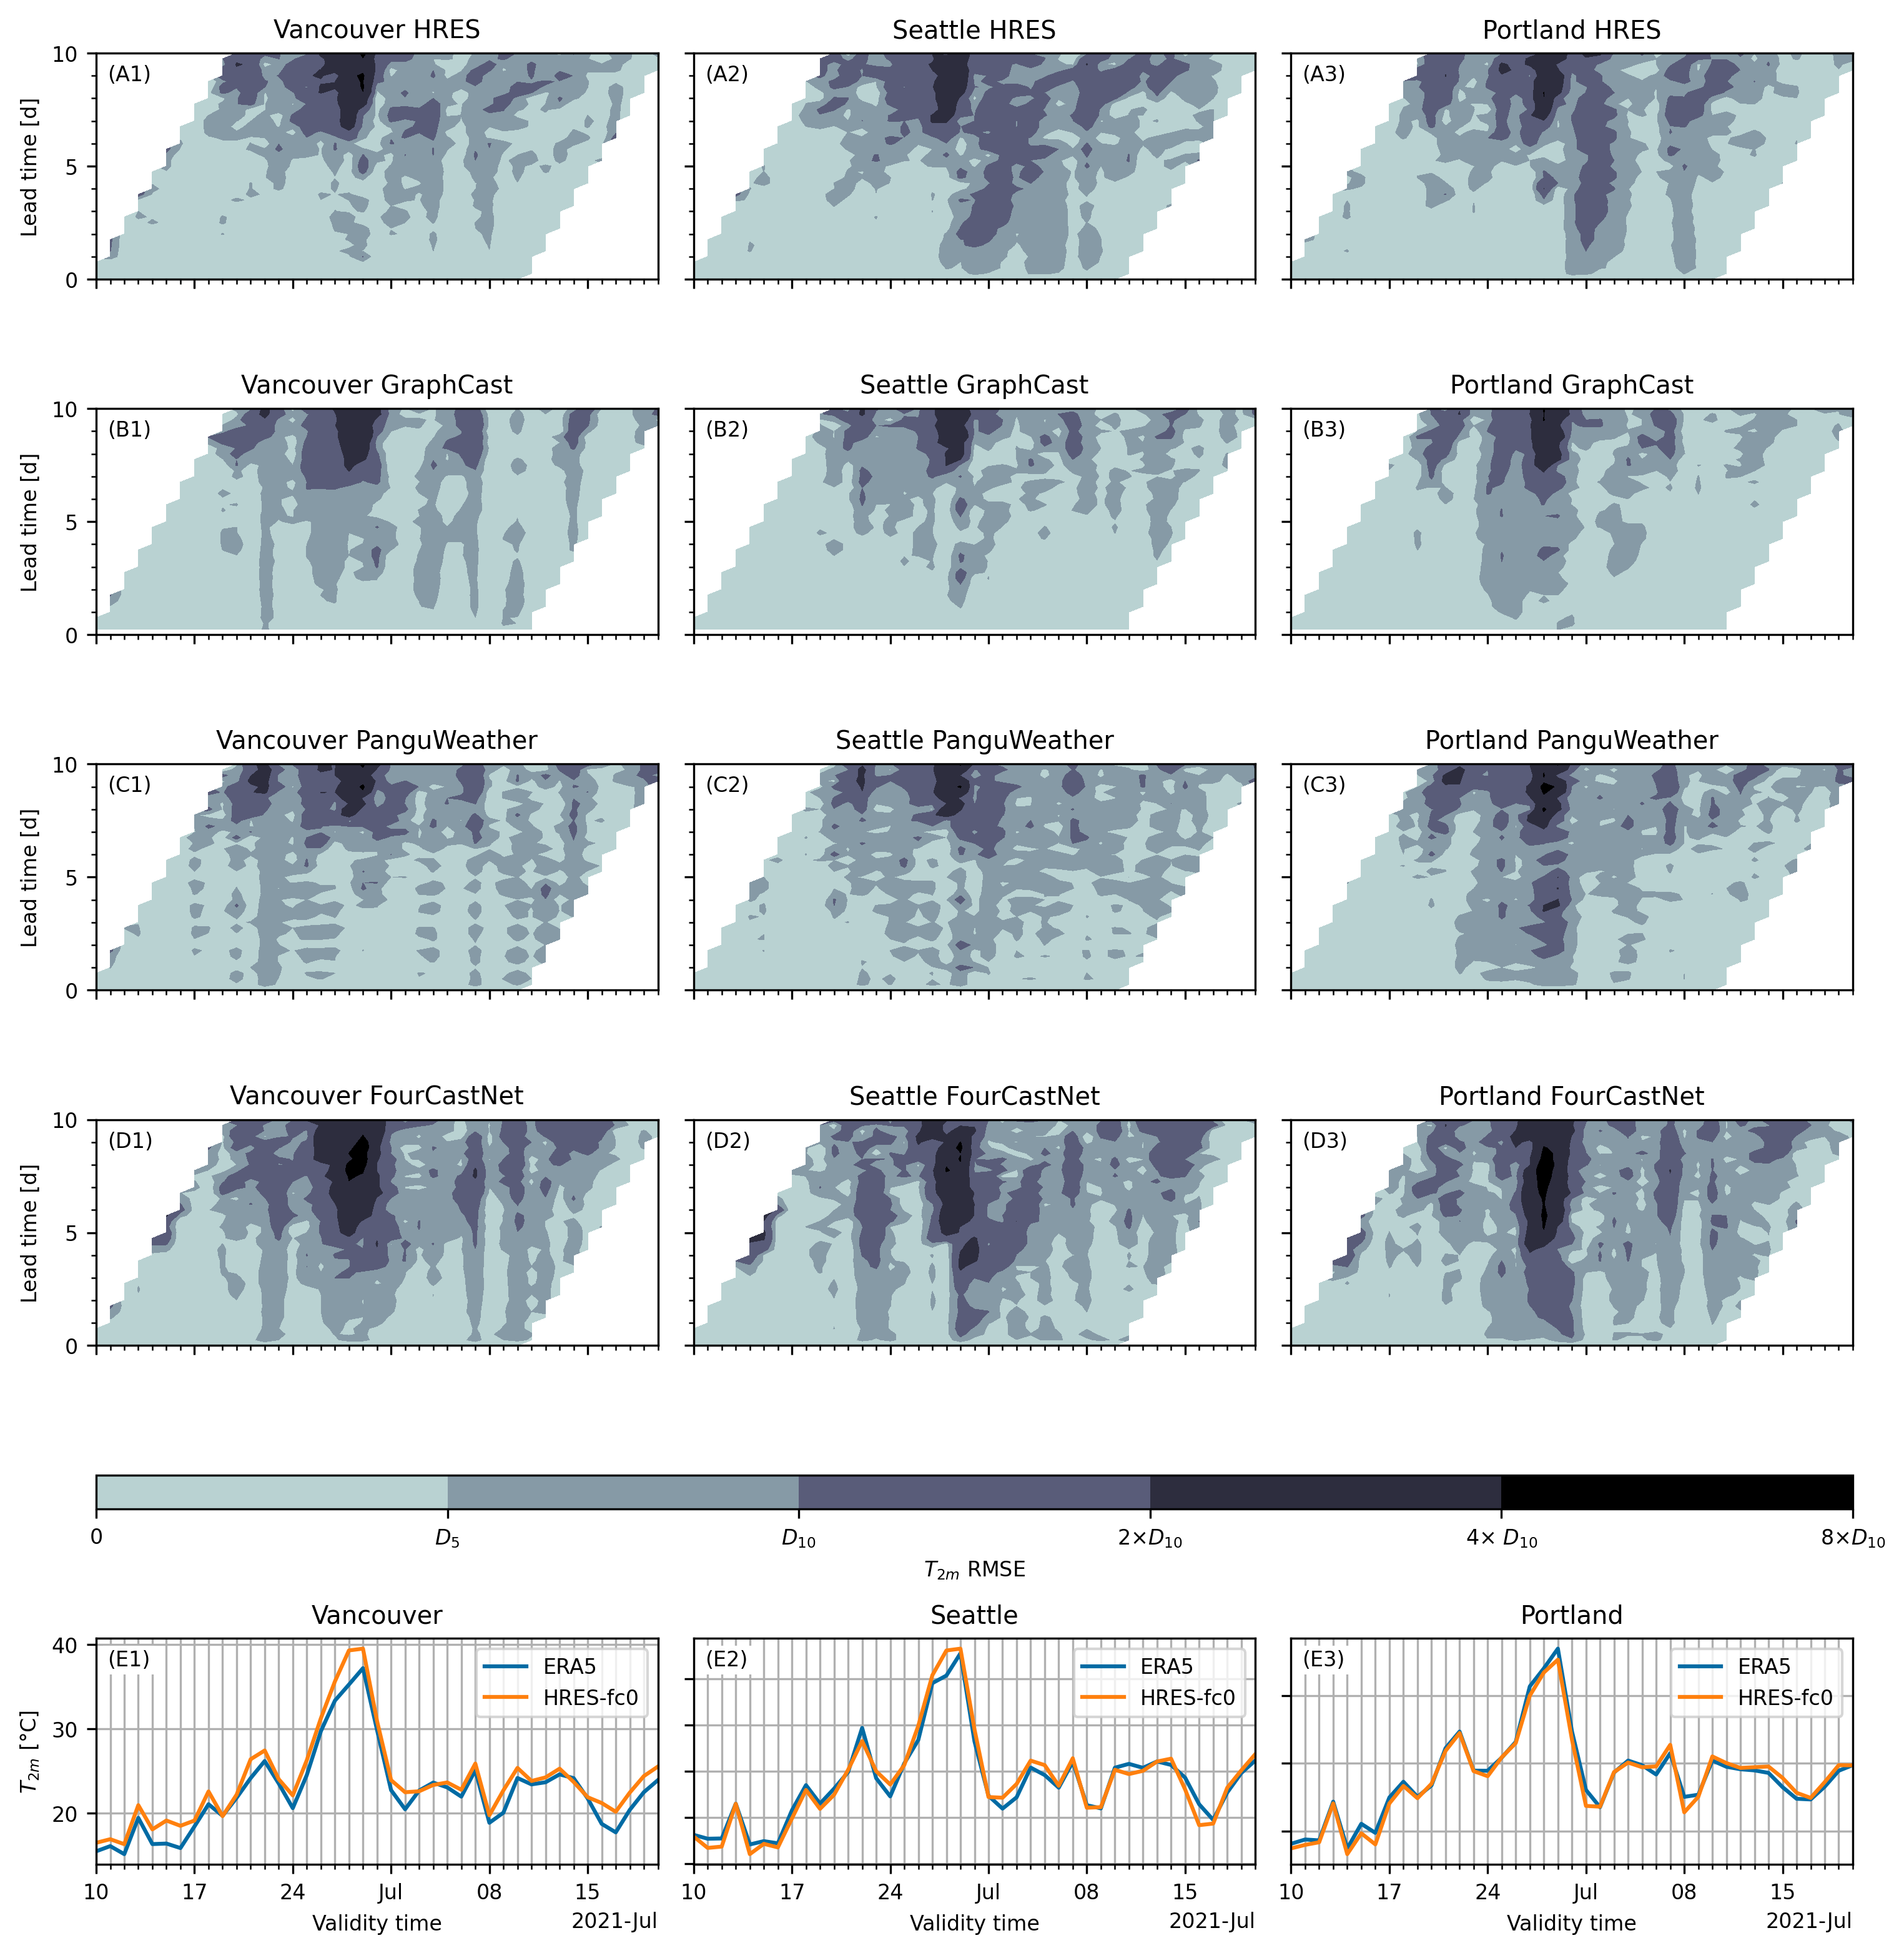

In [13]:
aspect_ratio_single_plot = 1.3

# this figure is too large to display it at normal textwidth. therefore increase width by factor
w_factor = 1.8
fig = plt.figure(
    figsize=(
        w_factor * textwidth,
        w_factor * textwidth / aspect_ratio_single_plot * 4 / 3,
    )
)
gs = gridspec.GridSpec(6, 3, figure=fig, height_ratios=4 * [1] + [0.15] + [1])

rmse_indices = [10, 20]  # forecasts with leadtime 120h, 240h

for j, label in enumerate(labels):
    ax_timeseries = fig.add_subplot(gs[-1, j])

    t_min = np.amin(gt_data.time).to_numpy()
    t_max = np.amax(gt_data.time).to_numpy()
    n_days = np.ceil((t_max - t_min) / np.timedelta64(1, "D"))
    ticks = t_min + np.timedelta64(1, "D") * np.arange(n_days)

    d = (
        kelvin_to_celsius(
            gt_data.sel({"latitude": lats[j], "longitude": lons[j], "source": "ERA5"})[
                "2m_temperature"
            ]
        )
        .groupby("time.date")
        .max()
    )
    d["date"] = d.date.astype("datetime64[ns]")
    d.plot(ax=ax_timeseries, label="ERA5")

    d = (
        kelvin_to_celsius(
            gt_data.sel(
                {"latitude": lats[j], "longitude": lons[j], "source": "HRES_t0"}
            )["2m_temperature"]
        )
        .groupby("time.date")
        .max()
    )
    d["date"] = d.date.astype("datetime64[ns]")
    d.plot(ax=ax_timeseries, label="HRES-fc0")

    ax_timeseries.set_xticks(ticks, minor=True)
    ax_timeseries.set_xticks(ticks[::7])
    ax_timeseries.set_xlim(np.amin(ticks), np.amax(ticks))
    ax_timeseries.set_title(f"{label}")
    if j == 0:
        ax_timeseries.set_ylabel("$T_{2m}$ [°C]")
    else:
        ax_timeseries.set_ylabel("")
        plt.setp(ax_timeseries.get_yticklabels(), visible=False)
    ax_timeseries.set_xlabel("Validity time")
    ax_timeseries.grid(visible=True, which="both")
    ax_timeseries.legend(loc="best")

    add_label_to_axes(ax_timeseries, label=f"({letters[len(forecast_names)]}{j+1})")

    for i, (fc_name, gt_name) in enumerate(
        zip(forecast_names, ground_truth_names, strict=True)
    ):
        fc = fc_data.sel(
            {"forecast": fc_name, "latitude": lats[j], "longitude": lons[j]}
        )["2m_temperature"]
        gt = gt_data.sel(
            {"source": gt_name, "latitude": lats[j], "longitude": lons[j]}
        )["2m_temperature"]

        rmse = get_rmse_time_mean_inside(fc=fc.compute(), gt=gt.compute())

        ax = fig.add_subplot(gs[i, j])

        dt = rmse.prediction_timedelta / np.timedelta64(1, "D")
        levels = [
            0,
            *rmse_mean[(lats[j], lons[j])][rmse_indices],
            2 * rmse_mean[(lats[j], lons[j])][-1],
            4 * rmse_mean[(lats[j], lons[j])][-1],
            8 * rmse_mean[(lats[j], lons[j])][-1],
        ]
        vals = np.linspace(0, 1, len(levels))

        contour = ax.contourf(
            rmse.date,
            dt,
            rmse.T,
            levels=levels,
            colors=np.array(plt.get_cmap("bone_r", len(levels))(vals))[1:],
        )

        # configure and plot grid.
        ax.set_yticks(np.arange(int(dt[-1] + 1)), minor=True)
        ax.set_yticks(np.arange(int(dt[-1] + 1))[::5])

        ax.set_xticks(ticks, minor=True)
        ax.set_xticks(ticks[::7])

        # hide x labels here.
        plt.setp(ax.get_xticklabels(), visible=False)

        if j == 0:
            ax.set_ylabel("Lead time [d]")
        else:
            ax.set_ylabel("")
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_title(f"{label} {fc_name}")

        add_label_to_axes(ax, label=f"({letters[i]}{j+1})")


ax_cb = plt.subplot(gs[-2, :])
cbar = plt.colorbar(
    mappable=contour,
    cax=ax_cb,
    extend="both",
    label="$T_{2m}$ RMSE",
    orientation="horizontal",
)

cbar.set_ticklabels(
    [
        0,
        r"$D_{5}$",
        r"$D_{10}$",
        r"2$\times D_{10}$",
        r"4$\times$ $D_{10}$",
        r"8$\times D_{10}$",
    ]
)


fig.canvas.draw()
plt.tight_layout()

plt.savefig("images/2021_PNW_heatwave_predictability_barrier_plots_rmse_all.png")

# Combine plots for multiple models in same Figure:

In [14]:
# dict of RMSE's:
rmse_models = {
    fc: get_rmse_time_mean_inside(
        fc=fc_data["2m_temperature"].sel({"forecast": fc}).compute(),
        gt=gt_data["2m_temperature"].sel({"source": gt}).compute(),
    )
    for (fc, gt) in zip(forecast_names, ground_truth_names, strict=True)
}
rmse_models = xr.concat(rmse_models.values(), dim="forecast").assign_coords(
    forecast=forecast_names
)

In [15]:
# custom color maps

# Define the starting point (RGB = White)
startingPoint = "#ffffff"

# Define the endpoint (RGB = Red)
endpoint1 = "#377eb8"
endpoint2 = "#ff7f00"
endpoint3 = "#4daf4a"
endpoint4 = "#984ea3"

cmaps = []

for e in [endpoint1, endpoint2, endpoint3, endpoint4]:
    # Create an array with both start and endpoints
    colorArray = [startingPoint, e]
    cmaps.append(LinearSegmentedColormap.from_list("mycolormap", colorArray))

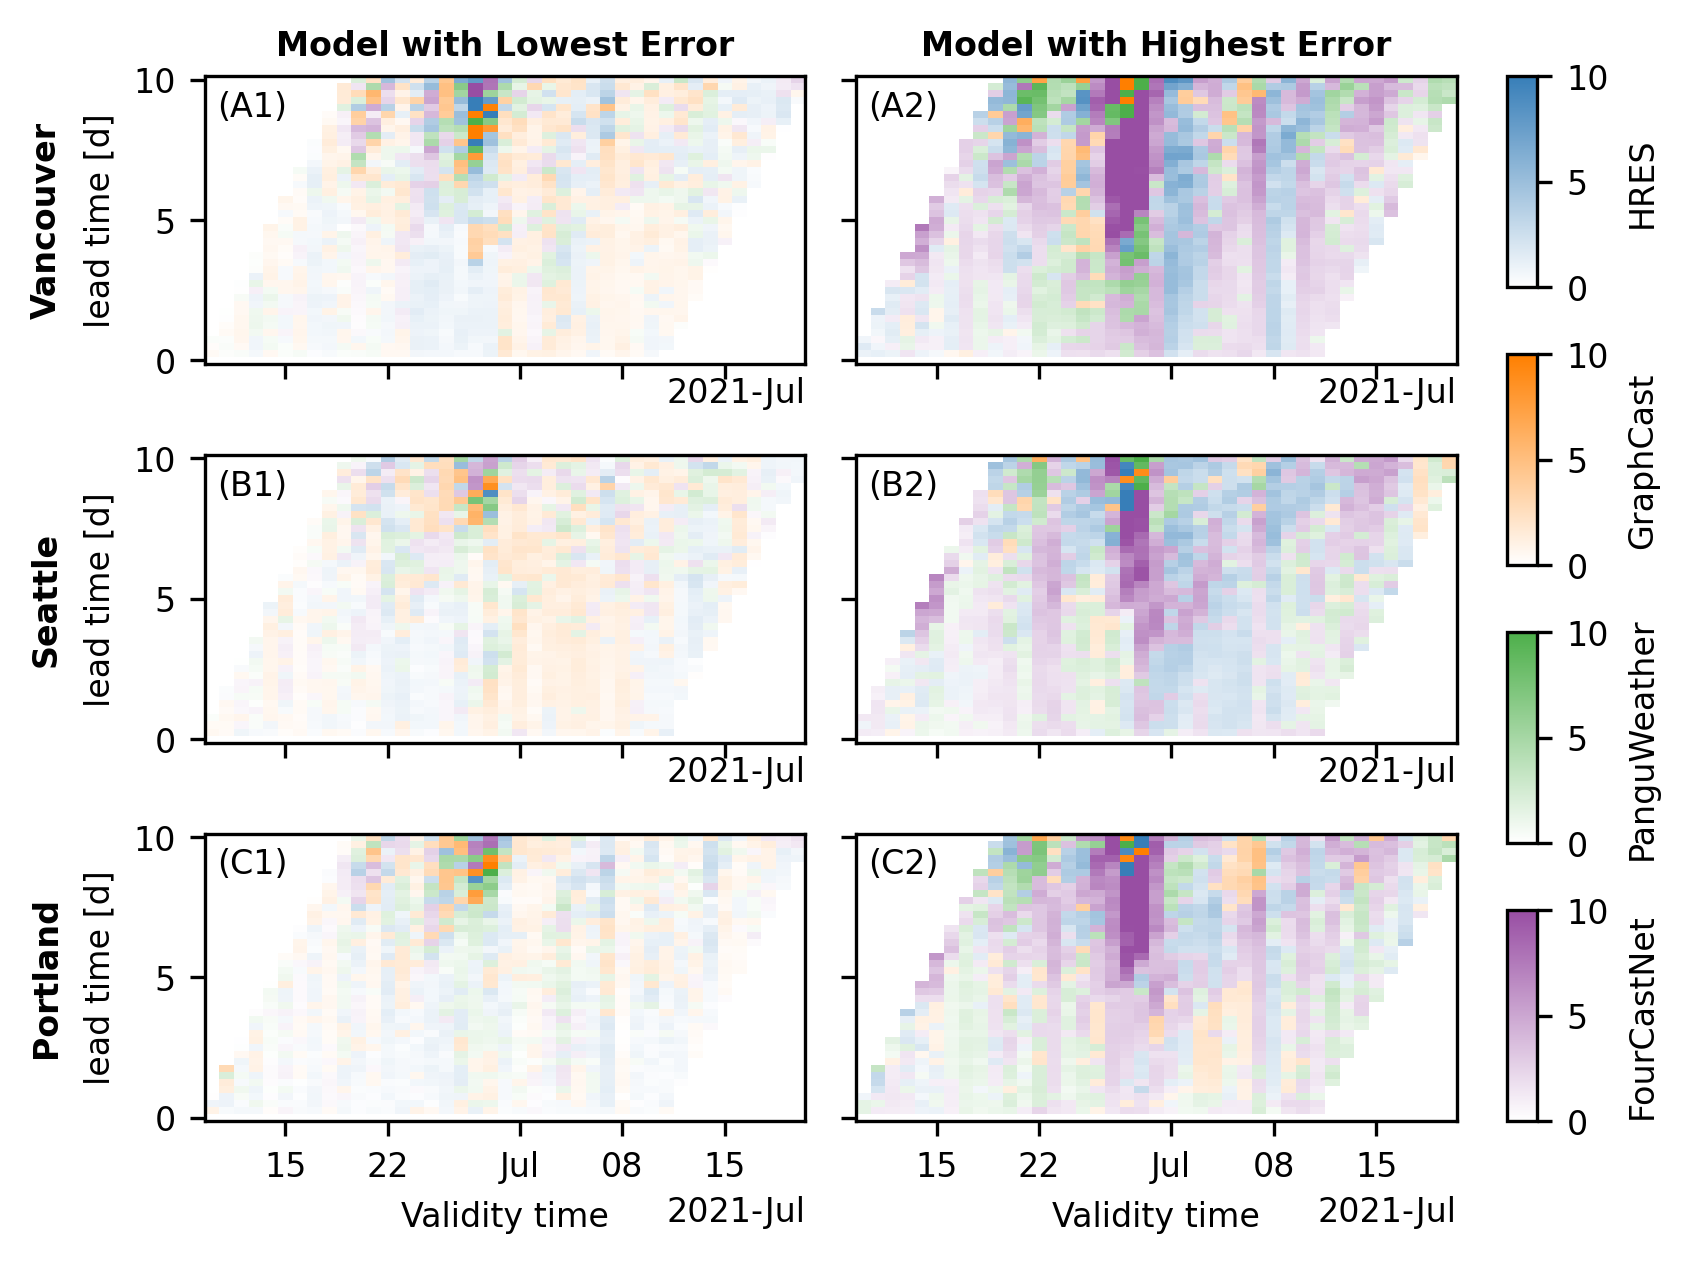

In [16]:
aspect_ratio_single_plot = 2
fig = plt.figure(
    figsize=(textwidth, textwidth / aspect_ratio_single_plot * len(labels) / 2)
)
gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.05])

ax = [[], []]
vmin = 0
vmax = 10

for i, (lat, lon) in enumerate(zip(lats, lons, strict=True)):
    if i > 0:
        ax[0].append(fig.add_subplot(gs[2 - i, 0], sharex=ax[0][0]))
    else:
        ax[0].append(fig.add_subplot(gs[2 - i, 0]))
    for j, fc in enumerate(rmse_models.forecast):
        m = (
            rmse_models.sel({"latitude": lat, "longitude": lon}).idxmin(dim="forecast")
            == fc
        )
        d = rmse_models.sel({"latitude": lat, "longitude": lon, "forecast": fc}).where(
            m
        )
        d = d.assign_coords(
            prediction_timedelta=(d.prediction_timedelta / np.timedelta64(1, "D"))
        )
        d = d.assign_coords(date=pd.to_datetime(d.date)).transpose()
        d.plot(ax=ax[0][-1], cmap=cmaps[j], vmin=vmin, vmax=vmax, add_colorbar=False)

    if i > 0:
        plt.setp(ax[0][i].get_xticklabels(), visible=False)
        ax[0][i].set_xlabel("")
    else:
        ax[0][i].set_xlabel("Validity time")
    ax[0][i].set_title("")
    ax[0][i].set_ylabel("lead time [d]")

    add_label_to_axes(ax[0][i], label=f"({letters[2-i]}1)")

for i, (lat, lon) in enumerate(zip(lats, lons, strict=True)):
    if i > 0:
        ax[1].append(fig.add_subplot(gs[2 - i, 1], sharex=ax[1][0], sharey=ax[0][i]))
    else:
        ax[1].append(fig.add_subplot(gs[2 - i, 1], sharey=ax[0][i]))
    for j, fc in enumerate(rmse_models.forecast):
        m = (
            rmse_models.sel({"latitude": lat, "longitude": lon}).idxmax(dim="forecast")
            == fc
        )
        d = rmse_models.sel({"latitude": lat, "longitude": lon, "forecast": fc}).where(
            m
        )
        d = d.assign_coords(
            prediction_timedelta=(d.prediction_timedelta / np.timedelta64(1, "D"))
        )
        d = d.assign_coords(date=pd.to_datetime(d.date)).transpose()
        d.plot(ax=ax[1][-1], cmap=cmaps[j], vmin=vmin, vmax=vmax, add_colorbar=False)
    if i > 0:
        plt.setp(ax[1][i].get_xticklabels(), visible=False)
        ax[1][i].set_xlabel("")
    else:
        ax[1][i].set_xlabel("Validity time")

    plt.setp(ax[1][i].get_yticklabels(), visible=False)
    ax[1][i].set_ylabel("")
    ax[1][i].set_title("")

    add_label_to_axes(ax[1][i], label=f"({letters[2-i]}2)")

gs_cb = gridspec.GridSpecFromSubplotSpec(
    len(rmse_models.forecast), 1, subplot_spec=gs[:, 2]
)

for j, fc in enumerate(rmse_models.forecast):
    ax = fig.add_subplot(gs_cb[j])
    cmap = cmaps[j]
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, label=fc.values)

add_headers(
    fig=fig,
    col_headers=["Model with Lowest Error", "Model with Highest Error", ""],
    row_headers=labels,
    cbar_headers=rmse_models.forecast.values,
    fontweight="bold",
    row_pad=30,
)

plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_best_worst_model.png")

# Get videos of heatwave anomaly.

Will be very helpful to get a spatio-temporal overview over the heatwave. Only display daily max, to avoid getting distracted with daily cycle.


In [17]:
daily_mean_fc = fc_data.groupby("time.date").mean()
daily_mean_fc = daily_mean_fc.rename(date="dayofyear").assign_coords(
    dayofyear=(
        "dayofyear",
        [d.timetuple().tm_yday for d in daily_mean_fc.date.to_numpy()],
    )
)
daily_anomaly_fc = daily_mean_fc - era5_climatology.mean("hour")

daily_mean_gt = gt_data.groupby("time.date").mean()
daily_mean_gt = daily_mean_gt.rename(date="dayofyear").assign_coords(
    dayofyear=(
        "dayofyear",
        [d.timetuple().tm_yday for d in daily_mean_gt.date.to_numpy()],
    )
)
daily_anomaly_gt = daily_mean_gt - era5_climatology.mean("hour")

In [18]:
doy_peak = pd.Timestamp(np.datetime64("2021-06-28")).dayofyear

dt_forecast_days = 7
dt_forecast = np.timedelta64(dt_forecast_days, "D")

dt_start = 7
dt_end = 7

# which days to include in the video.
# Days must be continuous but start and stop point can be brought closer together.
daysofyear = era5_climatology.dayofyear

daysofyear = daysofyear.sel(
    dayofyear=slice(
        doy_peak - dt_forecast_days - dt_start, doy_peak - dt_forecast_days + dt_end
    )
)

MovieWriter ffmpeg unavailable; using Pillow instead.


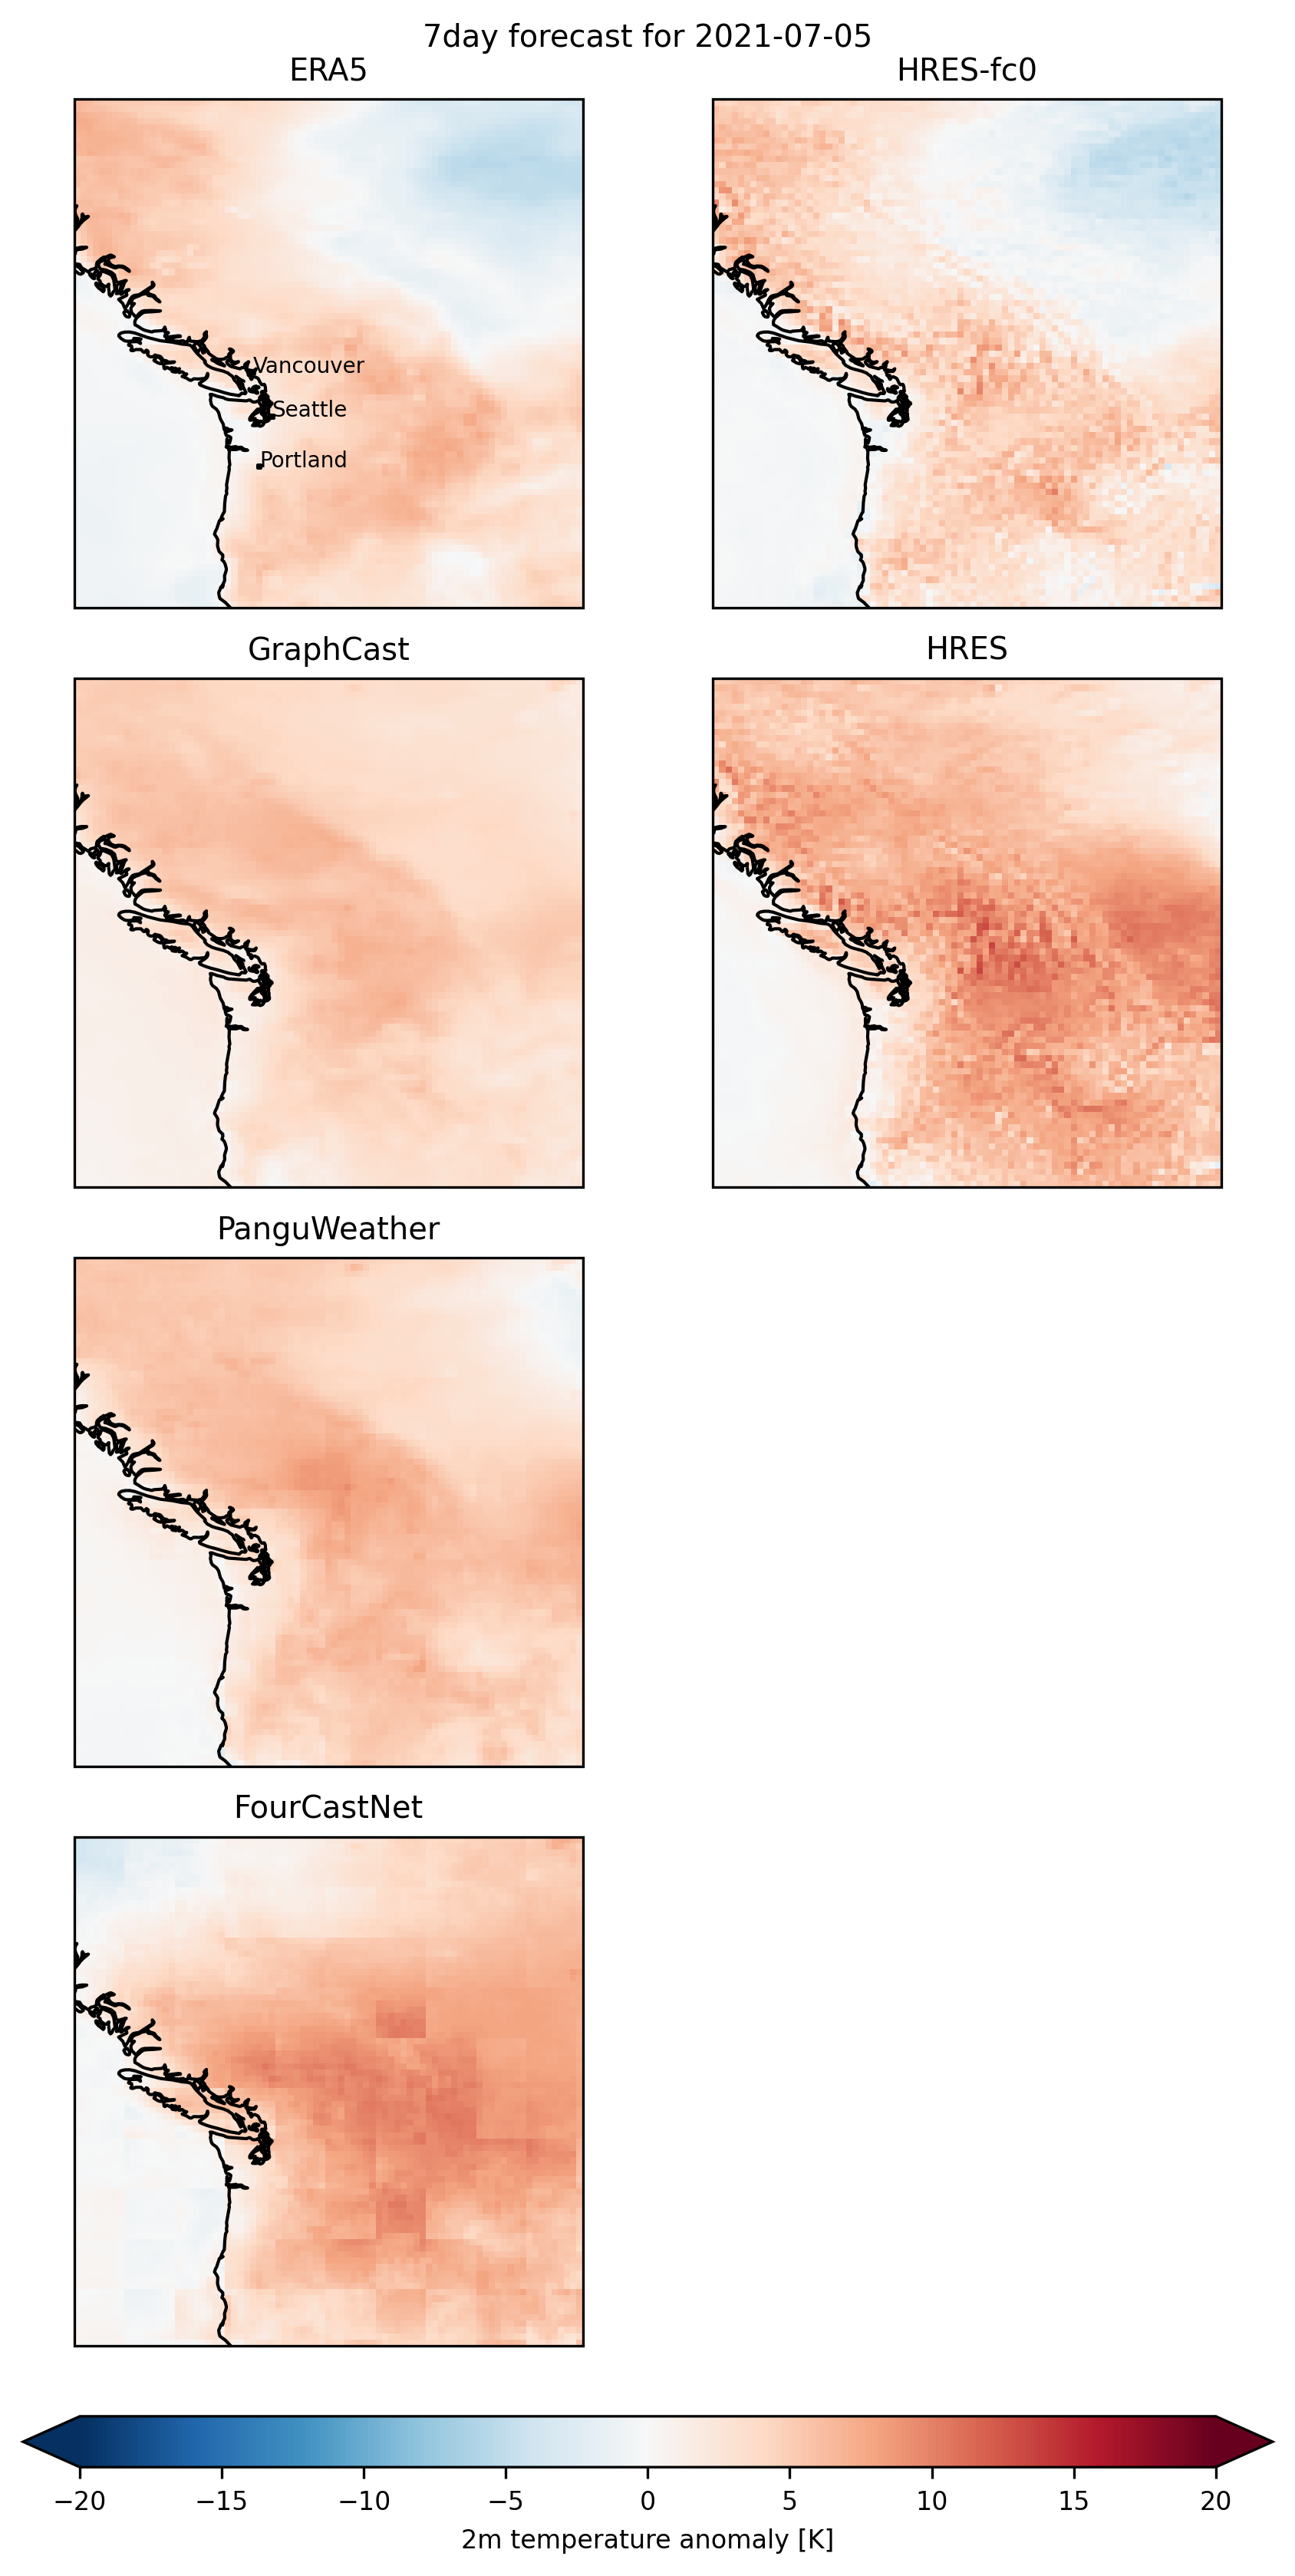

In [19]:
aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 4 / 2))
gs = gridspec.GridSpec(5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 0.1])

cmap = plt.get_cmap("RdBu_r")
norm = Normalize(vmin=-20, vmax=20)

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im_era5 = (
    daily_anomaly_gt["2m_temperature"]
    .sel({"source": "ERA5", "dayofyear": daysofyear[0 + dt_forecast_days]})
    .plot(
        ax=ax_era5,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_era5.set_title("ERA5")

ax_hres_t0 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im_hres_t0 = (
    daily_anomaly_gt["2m_temperature"]
    .sel({"source": "HRES_t0", "dayofyear": daysofyear[0 + dt_forecast_days]})
    .plot(
        ax=ax_hres_t0,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_hres_t0.set_title("HRES-fc0")

ax_graphCast = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im_graphCast = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "GraphCast",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_graphCast,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_graphCast.set_title("GraphCast")

ax_hres = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im_hres = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "HRES",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_hres,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_hres.set_title("HRES")

ax_pangu = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
im_pangu = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "PanguWeather",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_pangu,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_pangu.set_title("PanguWeather")

ax_fourcastnet = fig.add_subplot(gs[3, 0], projection=ccrs.PlateCarree())
im_fourcastnet = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "FourCastNet",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_fourcastnet,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_fourcastnet.set_title("FourCastNet")

ax_era5.coastlines()
ax_hres_t0.coastlines()
ax_hres.coastlines()
ax_graphCast.coastlines()
ax_pangu.coastlines()
ax_fourcastnet.coastlines()

ax_era5.scatter(lons, lats, transform=ccrs.PlateCarree(), c="k", marker="+", s=3)

for i, text in enumerate(labels):
    ax_era5.annotate(
        text, (lons[i], lats[i]), transform=ccrs.PlateCarree(), fontsize="small"
    )

fig.suptitle(
    f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[0] + dt_forecast_days, drop=True).values)[0]}"
)

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax_cbar,
    label="2m temperature anomaly [K]",
    orientation="horizontal",
    extend="both",
)
plt.tight_layout()


def update(i):
    im_era5.set_array(
        daily_anomaly_gt["2m_temperature"].sel(
            {"source": "ERA5", "dayofyear": daysofyear[i] + dt_forecast_days}
        )
    )
    im_hres_t0.set_array(
        daily_anomaly_gt["2m_temperature"].sel(
            {"source": "HRES_t0", "dayofyear": daysofyear[i] + dt_forecast_days}
        )
    )
    im_graphCast.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "GraphCast",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_hres.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "HRES",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_pangu.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "PanguWeather",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_fourcastnet.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "FourCastNet",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )

    fig.suptitle(
        f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[i] + dt_forecast_days, drop=True).values)[0]}"
    )

    return im_era5, im_hres, im_graphCast, im_hres, im_pangu, im_fourcastnet


animation_fig = FuncAnimation(
    fig,
    update,
    frames=len(daysofyear),
    interval=1500,
    blit=True,
    repeat_delay=10,
)
animation_fig.save("images/2021_PNW_heatwave_anomalies_RdBu.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


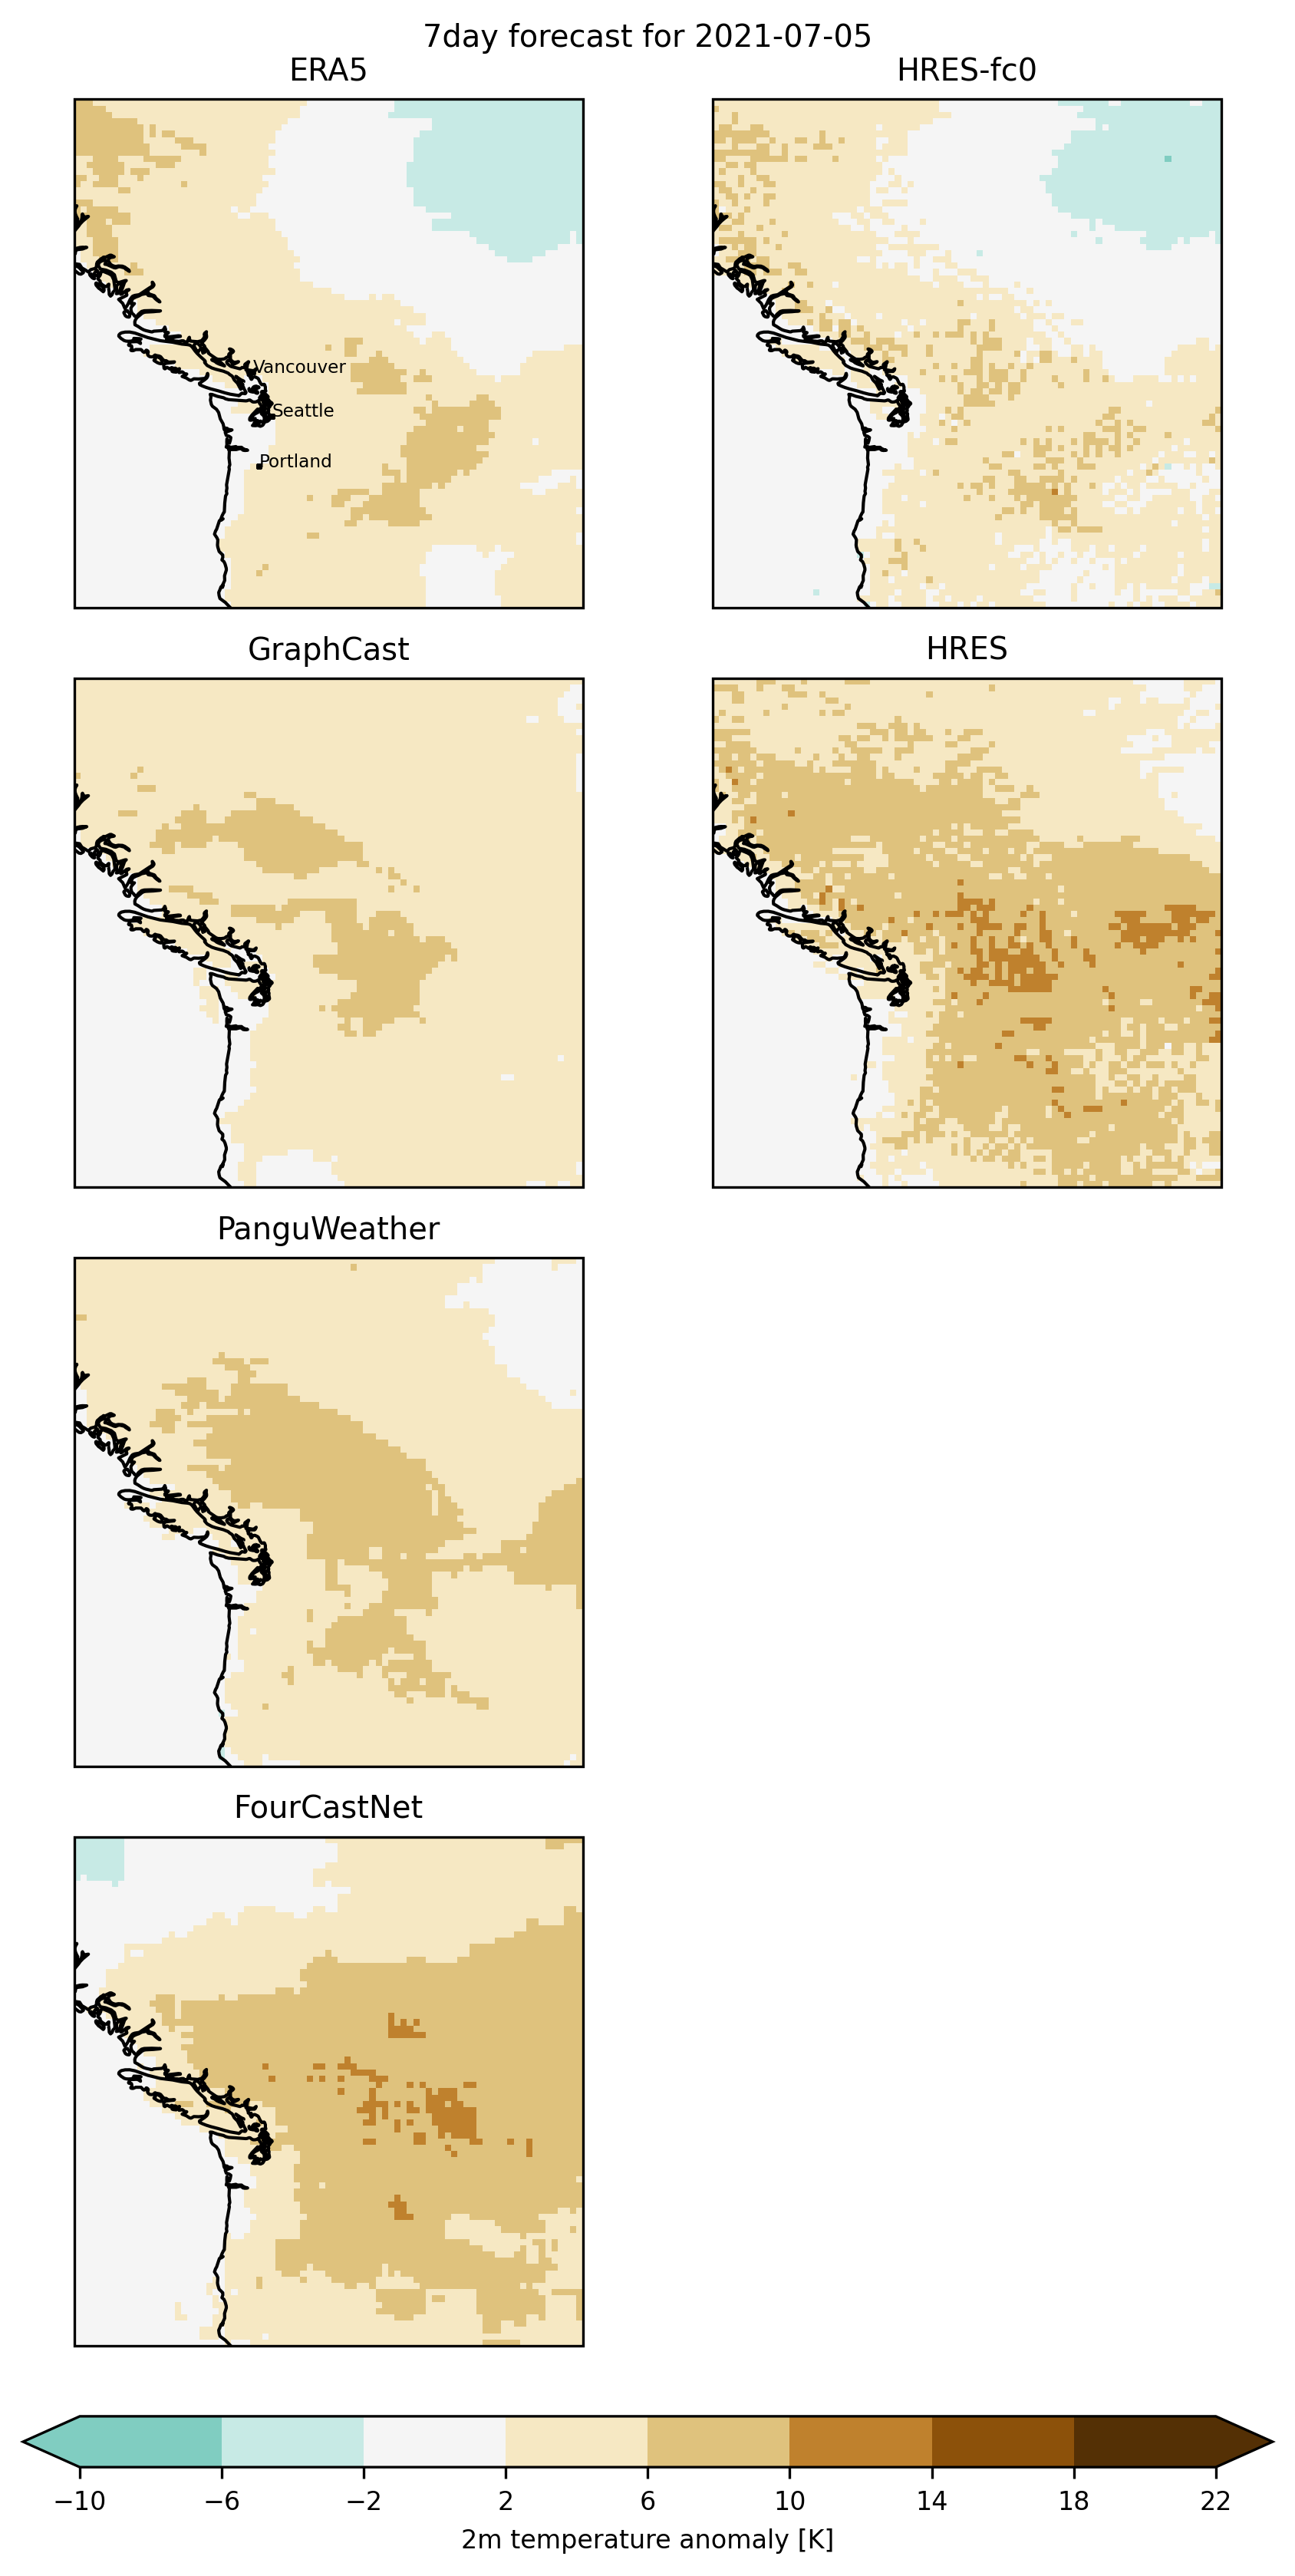

In [20]:
aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 4 / 2))
gs = gridspec.GridSpec(5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 0.1])

colours = [
    "#543005",
    "#8c510a",
    "#bf812d",
    "#dfc27d",
    "#f6e8c3",
    "#f5f5f5",
    "#c7eae5",
    "#80cdc1",
]
colours.reverse()
cmap = ListedColormap(colours)

bounds = np.array([-5, -3, -1, 1, 3, 5, 7, 9, 11]) * 2
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im_era5 = (
    daily_anomaly_gt["2m_temperature"]
    .sel({"source": "ERA5", "dayofyear": daysofyear[0] + dt_forecast_days})
    .plot(
        ax=ax_era5,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_era5.set_title("ERA5")

ax_hres_t0 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im_hres_t0 = (
    daily_anomaly_gt["2m_temperature"]
    .sel({"source": "HRES_t0", "dayofyear": daysofyear[0] + dt_forecast_days})
    .plot(
        ax=ax_hres_t0,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_hres_t0.set_title("HRES-fc0")

ax_graphCast = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im_graphCast = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "GraphCast",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_graphCast,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_graphCast.set_title("GraphCast")

ax_hres = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im_hres = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "HRES",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_hres,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_hres.set_title("HRES")

ax_pangu = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
im_pangu = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "PanguWeather",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_pangu,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_pangu.set_title("PanguWeather")

ax_fourcastnet = fig.add_subplot(gs[3, 0], projection=ccrs.PlateCarree())
im_fourcastnet = (
    daily_anomaly_fc["2m_temperature"]
    .sel(
        {
            "forecast": "FourCastNet",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
    .plot(
        ax=ax_fourcastnet,
        transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        animated=True,
        add_colorbar=False,
    )
)
ax_fourcastnet.set_title("FourCastNet")

ax_era5.coastlines()
ax_hres_t0.coastlines()
ax_hres.coastlines()
ax_graphCast.coastlines()
ax_pangu.coastlines()
ax_fourcastnet.coastlines()

ax_era5.scatter(lons, lats, transform=ccrs.PlateCarree(), c="k", marker="+", s=3)

for i, text in enumerate(labels):
    ax_era5.annotate(
        text, (lons[i], lats[i]), transform=ccrs.PlateCarree(), fontsize="x-small"
    )

fig.suptitle(
    f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[0] + dt_forecast_days, drop=True).values)[0]}"
)

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax_cbar,
    label="2m temperature anomaly [K]",
    orientation="horizontal",
    extend="both",
)
plt.tight_layout()


def update(i):
    im_era5.set_array(
        daily_anomaly_gt["2m_temperature"].sel(
            {"source": "ERA5", "dayofyear": daysofyear[i] + dt_forecast_days}
        )
    )
    im_hres_t0.set_array(
        daily_anomaly_gt["2m_temperature"].sel(
            {"source": "HRES_t0", "dayofyear": daysofyear[i] + dt_forecast_days}
        )
    )
    im_graphCast.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "GraphCast",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_hres.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "HRES",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_pangu.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "PanguWeather",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )
    im_fourcastnet.set_array(
        daily_anomaly_fc["2m_temperature"].sel(
            {
                "forecast": "FourCastNet",
                "dayofyear": daysofyear[i],
                "prediction_timedelta": dt_forecast,
            }
        )
    )

    fig.suptitle(
        f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[i] + dt_forecast_days, drop=True).values)[0]}"
    )

    return im_era5, im_hres, im_graphCast, im_hres, im_pangu, im_fourcastnet


animation_fig = FuncAnimation(
    fig,
    update,
    frames=len(daysofyear),
    interval=1000,
    blit=True,
    repeat_delay=10,
)
animation_fig.save("images/2021_PNW_heatwave_anomalies.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


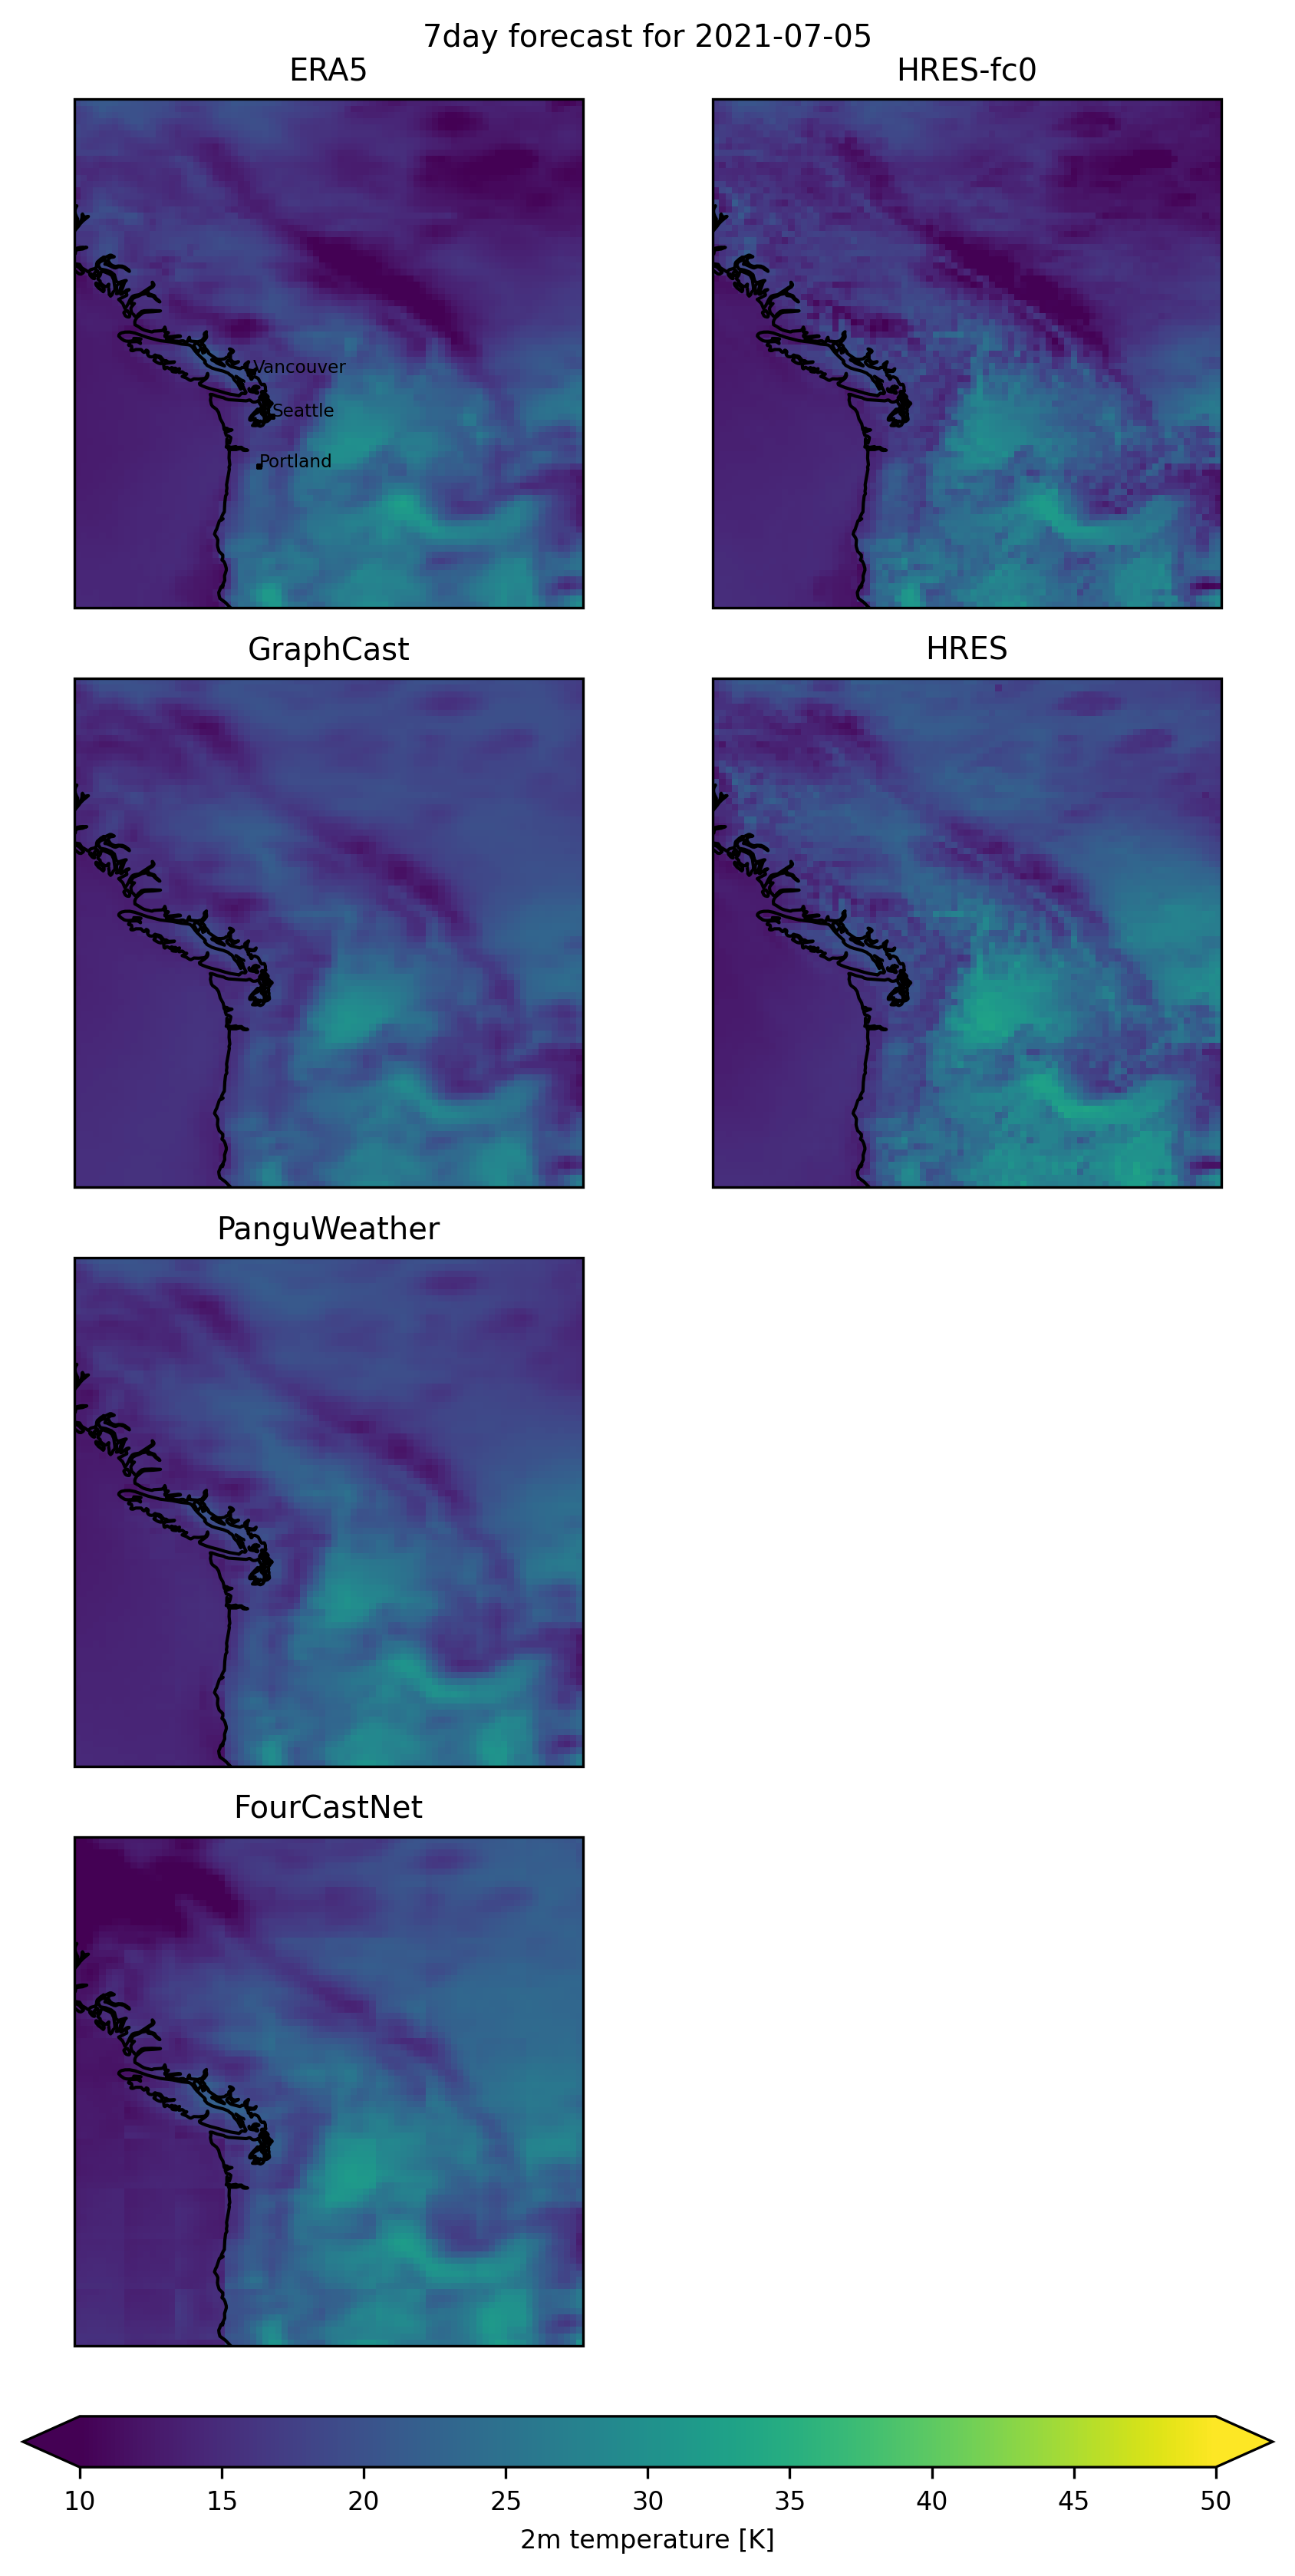

In [21]:
aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 4 / 2))
gs = gridspec.GridSpec(5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 0.1])

vmin = 10
vmax = 50

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im_era5 = kelvin_to_celsius(
    daily_mean_gt["2m_temperature"].sel(
        {"source": "ERA5", "dayofyear": daysofyear[0] + dt_forecast_days}
    )
).plot(
    ax=ax_era5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_era5.set_title("ERA5")

ax_hres_t0 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im_hres_t0 = kelvin_to_celsius(
    daily_mean_gt["2m_temperature"].sel(
        {"source": "HRES_t0", "dayofyear": daysofyear[0] + dt_forecast_days}
    )
).plot(
    ax=ax_hres_t0,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_hres_t0.set_title("HRES-fc0")

ax_graphCast = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im_graphCast = kelvin_to_celsius(
    daily_mean_fc["2m_temperature"].sel(
        {
            "forecast": "GraphCast",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
).plot(
    ax=ax_graphCast,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_graphCast.set_title("GraphCast")

ax_hres = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im_hres = kelvin_to_celsius(
    daily_mean_fc["2m_temperature"].sel(
        {
            "forecast": "HRES",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
).plot(
    ax=ax_hres,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_hres.set_title("HRES")

ax_pangu = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
im_pangu = kelvin_to_celsius(
    daily_mean_fc["2m_temperature"].sel(
        {
            "forecast": "PanguWeather",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
).plot(
    ax=ax_pangu,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_pangu.set_title("PanguWeather")

ax_fourcastnet = fig.add_subplot(gs[3, 0], projection=ccrs.PlateCarree())
im_fourcastnet = kelvin_to_celsius(
    daily_mean_fc["2m_temperature"].sel(
        {
            "forecast": "FourCastNet",
            "dayofyear": daysofyear[0],
            "prediction_timedelta": dt_forecast,
        }
    )
).plot(
    ax=ax_fourcastnet,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    animated=True,
    add_colorbar=False,
)
ax_fourcastnet.set_title("FourCastNet")

ax_era5.coastlines()
ax_hres_t0.coastlines()
ax_hres.coastlines()
ax_graphCast.coastlines()
ax_pangu.coastlines()
ax_fourcastnet.coastlines()

ax_era5.scatter(lons, lats, transform=ccrs.PlateCarree(), c="k", marker="+", s=3)

for i, text in enumerate(labels):
    ax_era5.annotate(
        text, (lons[i], lats[i]), transform=ccrs.PlateCarree(), fontsize="x-small"
    )

fig.suptitle(
    f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[0] + dt_forecast_days, drop=True).values)[0]}"
)

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    im_era5,
    cax=ax_cbar,
    label="2m temperature [K]",
    orientation="horizontal",
    extend="both",
)
plt.tight_layout()


def update(i):
    im_era5.set_array(
        kelvin_to_celsius(
            daily_mean_gt["2m_temperature"].sel(
                {"source": "ERA5", "dayofyear": daysofyear[i] + dt_forecast_days}
            )
        )
    )
    im_hres_t0.set_array(
        kelvin_to_celsius(
            daily_mean_gt["2m_temperature"].sel(
                {"source": "HRES_t0", "dayofyear": daysofyear[i] + dt_forecast_days}
            )
        )
    )
    im_graphCast.set_array(
        kelvin_to_celsius(
            daily_mean_fc["2m_temperature"].sel(
                {
                    "forecast": "GraphCast",
                    "dayofyear": daysofyear[i],
                    "prediction_timedelta": dt_forecast,
                }
            )
        )
    )
    im_hres.set_array(
        kelvin_to_celsius(
            daily_mean_fc["2m_temperature"].sel(
                {
                    "forecast": "HRES",
                    "dayofyear": daysofyear[i],
                    "prediction_timedelta": dt_forecast,
                }
            )
        )
    )
    im_pangu.set_array(
        kelvin_to_celsius(
            daily_mean_fc["2m_temperature"].sel(
                {
                    "forecast": "PanguWeather",
                    "dayofyear": daysofyear[i],
                    "prediction_timedelta": dt_forecast,
                }
            )
        )
    )
    im_fourcastnet.set_array(
        kelvin_to_celsius(
            daily_mean_fc["2m_temperature"].sel(
                {
                    "forecast": "FourCastNet",
                    "dayofyear": daysofyear[i],
                    "prediction_timedelta": dt_forecast,
                }
            )
        )
    )

    fig.suptitle(
        f"{dt_forecast_days}day forecast for {np.unique(gt_data.time.dt.date.where(gt_data.time.dt.dayofyear == daysofyear[i] + dt_forecast_days, drop=True).values)[0]}"
    )

    return im_era5, im_hres, im_graphCast, im_hres, im_pangu, im_fourcastnet


animation_fig = FuncAnimation(
    fig,
    update,
    frames=len(daysofyear),
    interval=1000,
    blit=True,
    repeat_delay=10,
)
animation_fig.save("images/2021_PNW_heatwave_absolute.gif")